In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
from scipy.stats import linregress
from matplotlib import cm

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

#### CURRENT BAD FILES ARE ALL GISS AND FGOALS-g3

### Open CMIP data

In [4]:
def open_aht(file, historical=False):

    final_times = pd.date_range('1980-01-01', '2014-12-31', freq='1M')
    
    final_lat = lats
    
    if historical == True:
        try:
            possible_ssp_file = file.replace('historical','ssp370')
            aht_ds = xr.open_mfdataset([file, possible_ssp_file])
        except FileNotFoundError:
            aht_ds = xr.open_dataset(file)

    else:
        aht_ds = xr.open_dataset(file)
    
    aht_ds = aht_ds.sel(time=slice('1980-01-01','2014-12-31'))

    aht_ds = aht_ds.interp(latitude=final_lat)
    
    try:
        aht_ds['time'] = final_times
    except ValueError:
        aht_ds = aht_ds.sel(time=slice('1980-01-01','2014-12-31'))
        aht_ds['time'] =  pd.date_range('1980-01-01', '2014-12-31', freq='1M')
    except:
        pass
    
    return aht_ds

In [5]:
#AMIP

aht_files_amip = glob.glob(f'*_amip_aht_ds.nc')
avoid_files_amip = []#['FGOALS-g3', 'GISS']

all_ahts_amip = []
model_list_amip = []

for file in aht_files_amip:
    if any(x in file for x in avoid_files_amip):
        print(f'Skipping {file}')
        
    else:
        all_ahts_amip.append(open_aht(file))
        model_list_amip.append(file.split('_')[0])
        
amip_ds = xr.concat(all_ahts_amip, pd.Index(model_list_amip, name='model'))

In [6]:
#Historical

aht_files_hist = glob.glob(f'*_historical_aht_ds.nc')
avoid_files_hist = []#['FGOALS-g3', 'GISS']

all_ahts_hist = []
model_list_hist = []

for file in aht_files_hist:
    if any(x in file for x in avoid_files_hist):
        print(f'Skipping {file}')
        
    else:
        all_ahts_hist.append(open_aht(file, historical=True))
        model_list_hist.append(file.split('_')[0])
        
hist_ds = xr.concat(all_ahts_hist, pd.Index(model_list_hist, name='model'))

hist_ds = hist_ds.compute()

In [7]:
### TEMP FIX FOR GISS ###
hist_ds['mmc_aht'][:,:,-3:] = 0
hist_ds['mmc_aht'][:,:,:3] = 0

hist_ds['mmc_aht_dry'][:,:,-3:] = 0
hist_ds['mmc_aht_dry'][:,:,:3] = 0

hist_ds['mmc_aht_dry_pot'][:,:,-3:] = 0
hist_ds['mmc_aht_dry_pot'][:,:,:3] = 0

hist_ds['mmc_aht_pot'][:,:,-3:] = 0
hist_ds['mmc_aht_pot'][:,:,:3] = 0

hist_ds['mmc_aht_moist'][:,:,-3:] = 0
hist_ds['mmc_aht_moist'][:,:,:3] = 0

hist_ds['te_aht'][:,:,-3:] = 0
hist_ds['te_aht'][:,:,:3] = 0

hist_ds['te_aht_dry_pot'][:,:,-3:] = 0
hist_ds['te_aht_dry_pot'][:,:,:3] = 0

hist_ds['te_aht_moist'][:,:,-3:] = 0
hist_ds['te_aht_moist'][:,:,:3] = 0

### TEMP FIX FOR GISS ###
amip_ds['mmc_aht'][:,:,-3:] = 0
amip_ds['mmc_aht'][:,:,:3] = 0

amip_ds['mmc_aht_dry'][:,:,-3:] = 0
amip_ds['mmc_aht_dry'][:,:,:3] = 0

amip_ds['mmc_aht_dry_pot'][:,:,-3:] = 0
amip_ds['mmc_aht_dry_pot'][:,:,:3] = 0

amip_ds['mmc_aht_pot'][:,:,-3:] = 0
amip_ds['mmc_aht_pot'][:,:,:3] = 0

amip_ds['mmc_aht_moist'][:,:,-3:] = 0
amip_ds['mmc_aht_moist'][:,:,:3] = 0

amip_ds['te_aht'][:,:,-3:] = 0
amip_ds['te_aht'][:,:,:3] = 0

amip_ds['te_aht_dry_pot'][:,:,-3:] = 0
amip_ds['te_aht_dry_pot'][:,:,:3] = 0

amip_ds['te_aht_moist'][:,:,-3:] = 0
amip_ds['te_aht_moist'][:,:,:3] = 0

#Temp fix as eddy AHT is weird
amip_ds['eddy_aht'] = amip_ds.se_aht + amip_ds.te_aht
amip_ds['eddy_aht_moist'] = amip_ds.se_aht_moist + amip_ds.te_aht_moist
amip_ds['eddy_aht_dry_pot'] = amip_ds.se_aht_dry_pot + amip_ds.te_aht_dry_pot

hist_ds['eddy_aht'] = hist_ds.se_aht + hist_ds.te_aht
hist_ds['eddy_aht_moist'] = hist_ds.se_aht_moist + hist_ds.te_aht_moist
hist_ds['eddy_aht_dry_pot'] = hist_ds.se_aht_dry_pot + hist_ds.te_aht_dry_pot

In [8]:

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)


def trend(x):
    return x.polyfit('time', deg=1)

#Output is in W/ns, so we convert to PW/40yrs
amip_trends_month = amip_ds.groupby('time.month').apply(trend) * 1e9 * 3600 * 24 * 365 * 40 / 1e15
hist_trends_month = hist_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15

amip_month = amip_ds.groupby('time.month').mean('time')
hist_month = hist_ds.groupby('time.month').mean('time')

In [87]:
#amip_ds.to_netcdf('../AHT_trends_work/amip_aht.nc')
#hist_ds.to_netcdf('../AHT_trends_work/hist_aht.nc')

### Load in CESM2 LE runs

In [9]:
#All CESM runs are offset by one month - need to fix this

cesm2_time = pd.date_range("1950-01-01","2014-12-31",freq='1M')
cesm2_le_ds_full = xr.open_dataset('../CESM_aht/CESM2_LENS2_aht_ds.nc')
cesm2_le_ds_full['time'] = cesm2_time
cesm2_le_ds = cesm2_le_ds_full.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_amip_time = pd.date_range("1949-12-31","2014-11-30",freq='1M')

cesm2_amip_le_ds = xr.open_dataset('../CESM_aht/CESM2_GOGA_AMIP_aht_ds.nc')
cesm2_amip_le_ds['time'] = cesm2_amip_time
cesm2_amip_le_ds = cesm2_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_toga_amip_le_ds = xr.open_dataset('../CESM_aht/CESM2_TOGA_AMIP_aht_ds.nc')
cesm2_toga_amip_le_ds['time'] = cesm2_amip_time
cesm2_toga_amip_le_ds = cesm2_toga_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_le_trends = cesm2_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_amip_le_trends = cesm2_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_toga_amip_le_trends = cesm2_toga_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

cesm2_month = cesm2_le_ds.groupby('time.month').mean('time')
cesm2_amip_month = cesm2_amip_le_ds.groupby('time.month').mean('time')
cesm2_toga_amip_month = cesm2_toga_amip_le_ds.groupby('time.month').mean('time')

cesm2_le_trends_month = cesm2_le_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15
cesm2_amip_le_trends_month = cesm2_amip_le_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15
cesm2_toga_amip_le_trends_month = cesm2_toga_amip_le_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15

### Load in reanalysis

In [10]:
reanalysis_time_slice = slice('1980-01-01','2014-12-31')

era5_ds = xr.open_dataset('../era5_data/era5_aht_ds_1979_2022.nc').sel(time=reanalysis_time_slice)
#era_interim_ds = xr.open_dataset('../era_interim/era_interim_aht.nc').sel(time=reanalysis_time_slice)
merra_ds = xr.open_dataset('../merra_data/merra_aht_1980_2022.nc').sel(time=reanalysis_time_slice)
jra_ds = xr.open_dataset('../JRA_aht/jra_aht_1959_2022.nc').sel(time=reanalysis_time_slice)


#Times mean the same thing, this makes them actually identical
merra_ds['time'] = era5_ds.time
jra_ds['time'] = era5_ds.time

#For now merra strm_fnct has bad coordinate name
merra_strm = merra_ds.strm_fnct.values
merra_ds = merra_ds.drop('strm_fnct')
merra_ds = merra_ds.assign(dict(strm_fnct=(['time','level', 'latitude'], merra_strm)))

#Now interp everything to common coordinates
era5_ds = era5_ds.interp(latitude=lats, level=levels_hPa)
#era_interim_ds = era_interim_ds.interp(latitude=lats, level=levels_hPa)
merra_ds = merra_ds.interp(latitude=lats, level=levels_hPa)
jra_ds = jra_ds.interp(latitude=lats, level=levels_hPa)

ds_vars = ['total_aht', 'total_aht_dry', 'total_aht_dry_pot', 'total_aht_moist',
           'te_aht', 'te_aht_dry', 'te_aht_dry_pot', 'te_aht_moist',
           'se_aht', 'se_aht_dry', 'se_aht_dry_pot', 'se_aht_moist',
           'mmc_aht', 'mmc_aht_dry', 'mmc_aht_dry_pot', 'mmc_aht_moist',
           'eddy_aht', 'eddy_aht_dry', 'eddy_aht_dry_pot', 'eddy_aht_moist',
           'strm_fnct', 'mse_surf']

#reanalysis_ds = xr.concat([era5_ds[ds_vars], era_interim_ds[ds_vars], merra_ds[ds_vars], jra_ds[ds_vars]],
                          #pd.Index(['ERA5', 'ERA-Interim', 'MERRA', 'JRA'], name='model'))
reanalysis_ds = xr.concat([era5_ds[ds_vars],  merra_ds[ds_vars], jra_ds[ds_vars]],
                          pd.Index(['ERA5',  'MERRA', 'JRA'], name='model'))
reanalysis_month = reanalysis_ds.groupby('time.month').mean('time')

reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends_month = reanalysis_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15



In [88]:
#reanalysis_ds.to_netcdf('../AHT_trends_work/reanalysis_aht.nc')

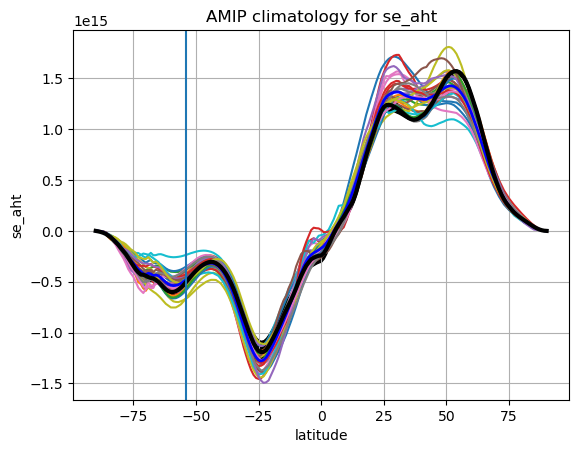

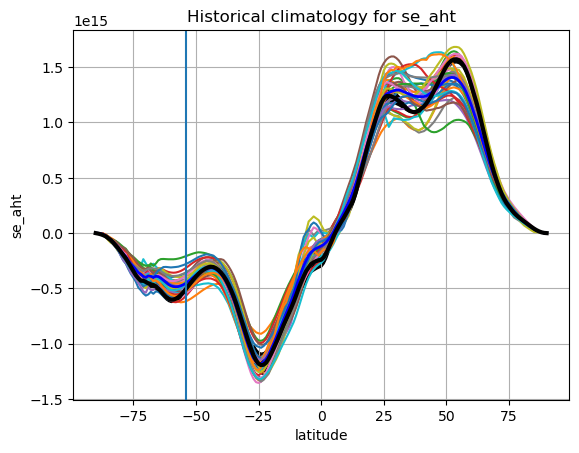

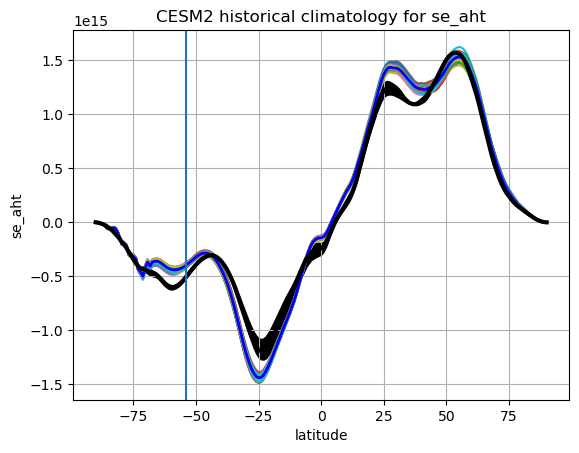

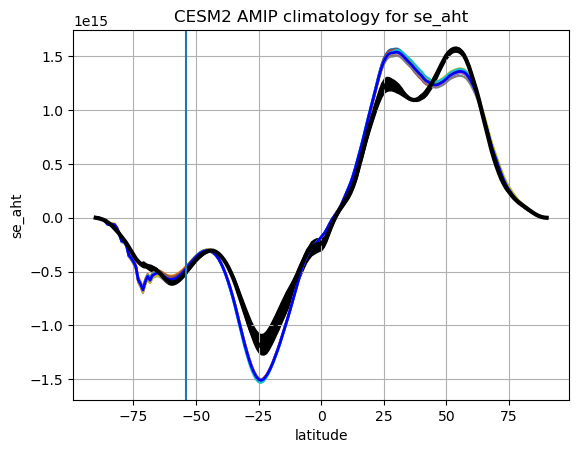

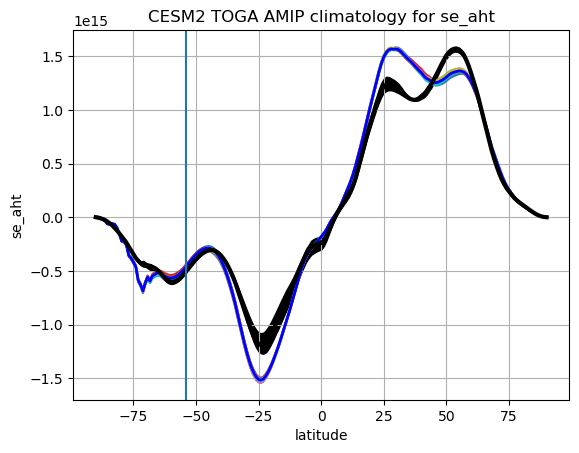

In [11]:
field = 'se_aht'

(amip_ds[field].mean('time')).plot.line(x='latitude', add_legend=False)
(amip_ds[field].mean(['time', 'model'])).plot.line(x='latitude', color='b', lw=2, add_legend=False)
(reanalysis_ds[field].mean(['model', 'time'])).plot(color='k', lw=3)
plt.fill_between(lats,
                     reanalysis_ds[field].mean(['time']).min('model'),
                     reanalysis_ds[field].mean(['time']).max('model'),
                     color='k', alpha=1)

plt.axvline(-54)
plt.title(f'AMIP climatology for {field}')
plt.grid()
plt.show()

(hist_ds[field].mean('time')).plot.line(x='latitude', add_legend=False)
(hist_ds[field].mean(['time', 'model'])).plot.line(x='latitude', color='b', lw=2, add_legend=False)
(reanalysis_ds[field].mean(['model', 'time'])).plot(color='k', lw=3)
plt.fill_between(lats,
                     reanalysis_ds[field].mean(['time']).min('model'),
                     reanalysis_ds[field].mean(['time']).max('model'),
                     color='k', alpha=1)

plt.axvline(-54)
plt.title(f'Historical climatology for {field}')
plt.grid()
plt.show()

(cesm2_le_ds[field].mean('time')).plot.line(x='latitude', add_legend=False)
(cesm2_le_ds[field].mean(['time', 'model'])).plot.line(x='latitude', color='b', lw=2, add_legend=False)
(reanalysis_ds[field].mean(['model', 'time'])).plot(color='k', lw=3)
plt.fill_between(lats,
                     reanalysis_ds[field].mean(['time']).min('model'),
                     reanalysis_ds[field].mean(['time']).max('model'),
                     color='k', alpha=1)

plt.axvline(-54)
plt.title(f'CESM2 historical climatology for {field}')
plt.grid()
plt.show()

(cesm2_amip_le_ds[field].mean('time')).plot.line(x='latitude', add_legend=False)
(cesm2_amip_le_ds[field].mean(['time', 'model'])).plot.line(x='latitude', color='b', lw=2, add_legend=False)
(reanalysis_ds[field].mean(['model', 'time'])).plot(color='k', lw=3)
plt.fill_between(lats,
                     reanalysis_ds[field].mean(['time']).min('model'),
                     reanalysis_ds[field].mean(['time']).max('model'),
                     color='k', alpha=1)

plt.axvline(-54)
plt.title(f'CESM2 AMIP climatology for {field}')
plt.grid()
plt.show()

(cesm2_toga_amip_le_ds[field].mean('time')).plot.line(x='latitude', add_legend=False)
(cesm2_toga_amip_le_ds[field].mean(['time', 'model'])).plot.line(x='latitude', color='b', lw=2, add_legend=False)
(reanalysis_ds[field].mean(['model', 'time'])).plot(color='k', lw=3)
plt.fill_between(lats,
                     reanalysis_ds[field].mean(['time']).min('model'),
                     reanalysis_ds[field].mean(['time']).max('model'),
                     color='k', alpha=1)

plt.axvline(-54)
plt.title(f'CESM2 TOGA AMIP climatology for {field}')
plt.grid()
plt.show()

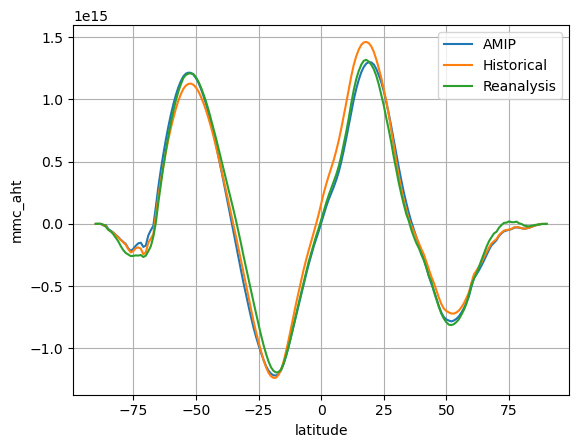

In [12]:
field = 'mmc_aht'

amip_ds[field].mean(['time', 'model']).plot.line(x='latitude', label='AMIP')
hist_ds[field].mean(['time', 'model']).plot.line(x='latitude', label='Historical')
reanalysis_ds[field].mean(['time', 'model']).plot.line(x='latitude', label='Reanalysis')

plt.legend(loc=0)
plt.grid()
plt.show()

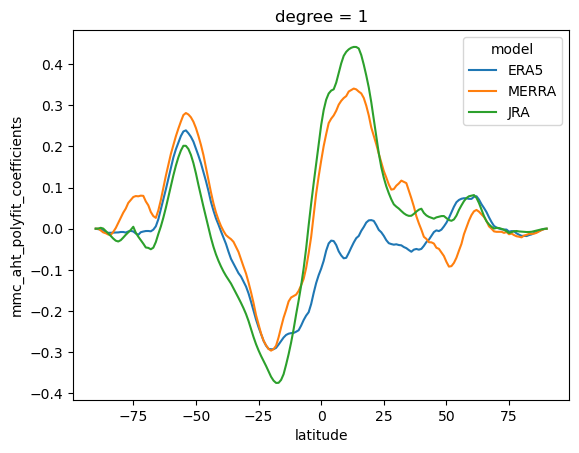

In [13]:
(40 * reanalysis_trends['mmc_aht_polyfit_coefficients'].sel(degree=1)/1e15).plot.line(x='latitude', label='Reanalysis')

plt.show()

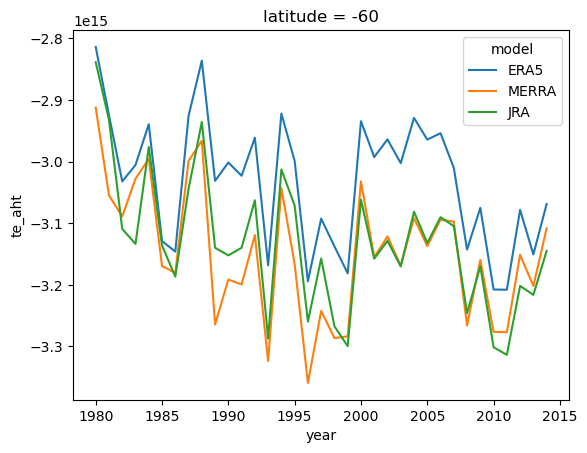

In [14]:
reanalysis_ds.te_aht.sel(latitude=-60).groupby('time.year').mean('time').plot.line(x='year')
plt.show()

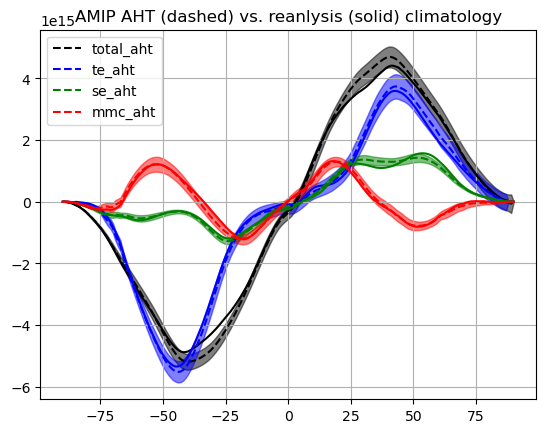

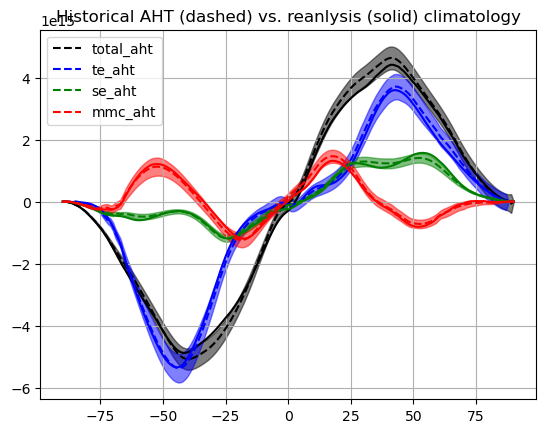

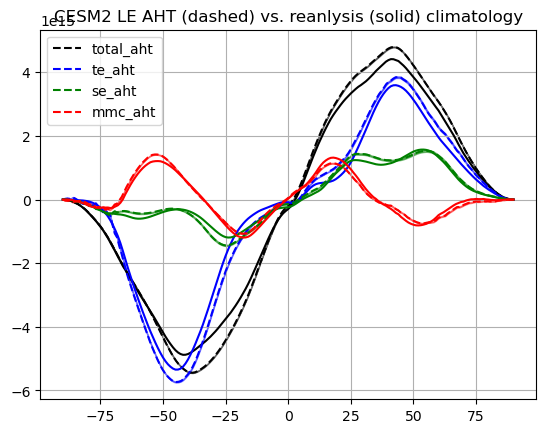

In [15]:
#Make reanalysis mean
fields = ['total_aht', 'te_aht', 'se_aht', 'mmc_aht']
colors_dict = dict(zip(fields, ['k', 'b', 'g', 'r']))

for field in fields:
    plt.fill_between(lats,
                     amip_ds[field].mean(['model', 'time']) + amip_ds[field].mean(['time']).std('model'),
                     amip_ds[field].mean(['model', 'time']) - amip_ds[field].mean(['time']).std('model'),
                     color=colors_dict[field], alpha=0.5)

    plt.plot(lats, amip_ds[field].mean(['model', 'time']), '--', color=colors_dict[field], label=field)
    plt.plot(lats, reanalysis_ds[field].mean(['model', 'time']), '-', color=colors_dict[field])


plt.grid()
plt.legend(loc=0)
plt.title('AMIP AHT (dashed) vs. reanlysis (solid) climatology')
#plt.savefig('../figures/1_20_23_meeting/amip_aht_climatology')
plt.show()

for field in fields:
    plt.fill_between(lats,
                     hist_ds[field].mean(['model', 'time']) + hist_ds[field].mean(['time']).std('model'),
                     hist_ds[field].mean(['model', 'time']) - hist_ds[field].mean(['time']).std('model'),
                     color=colors_dict[field], alpha=0.5)

    plt.plot(lats, hist_ds[field].mean(['model', 'time']), '--', color=colors_dict[field], label=field)
    plt.plot(lats, reanalysis_ds[field].mean(['model', 'time']), '-', color=colors_dict[field])


plt.grid()
plt.legend(loc=0)
plt.title('Historical AHT (dashed) vs. reanlysis (solid) climatology')
#plt.savefig('../figures/1_20_23_meeting/hist_aht_climatology')
plt.show()

for field in fields:
    plt.fill_between(cesm2_le_ds.latitude,
                     cesm2_le_ds[field].mean(['model', 'time']) + cesm2_le_ds[field].mean(['time']).std('model'),
                     cesm2_le_ds[field].mean(['model', 'time']) - cesm2_le_ds[field].mean(['time']).std('model'),
                     color=colors_dict[field], alpha=0.5)

    plt.plot(cesm2_le_ds.latitude, cesm2_le_ds[field].mean(['model', 'time']), '--', color=colors_dict[field], label=field)
    plt.plot(lats, reanalysis_ds[field].mean(['model', 'time']), '-', color=colors_dict[field])


plt.grid()
plt.legend(loc=0)
plt.title('CESM2 LE AHT (dashed) vs. reanlysis (solid) climatology')
#plt.savefig('../figures/1_20_23_meeting/cesm2_aht_climatology')
plt.show()

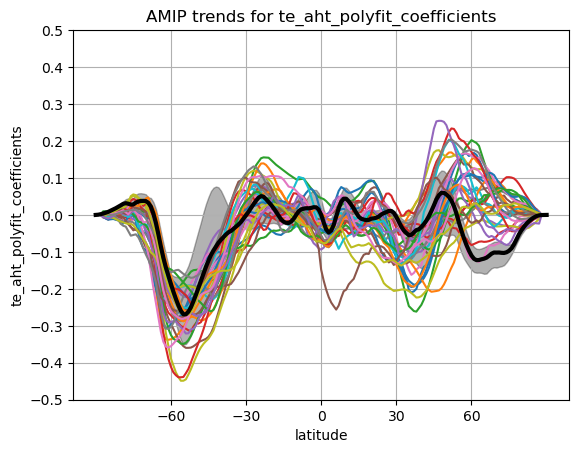

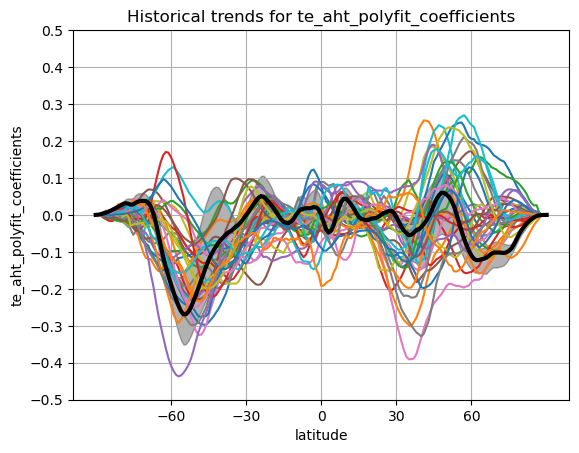

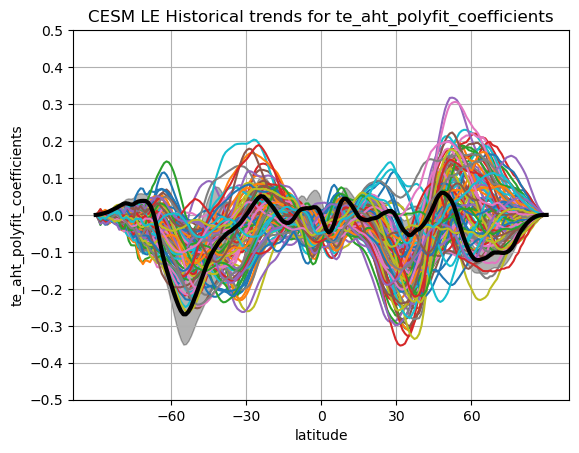

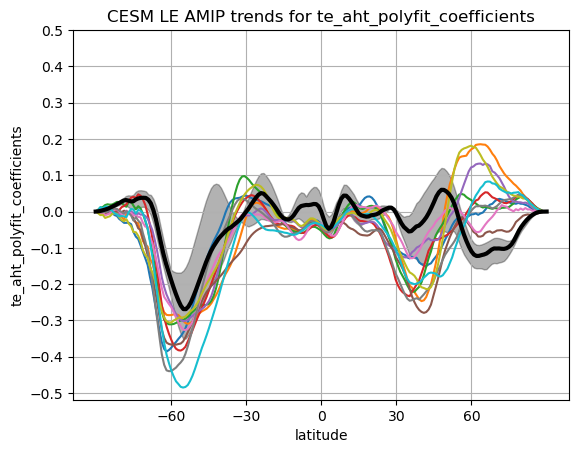

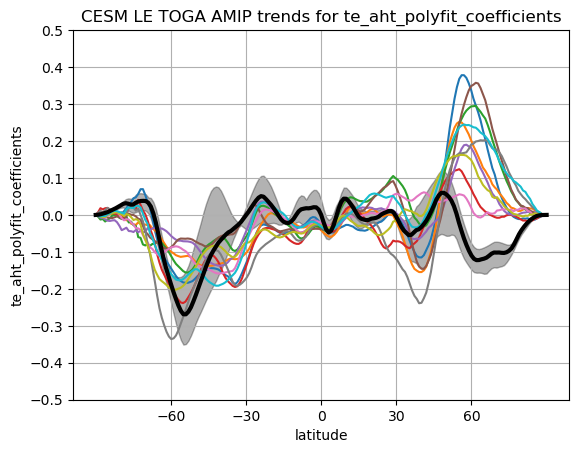

In [84]:
field = 'te_aht_polyfit_coefficients'

(40 * amip_trends[field].sel(degree=1) / 1e15).plot.line(x='latitude', add_legend=False)
(40 * reanalysis_trends[field].sel(degree=1).mean('model') / 1e15).plot(color='k', lw=3)
plt.fill_between(lats,
                 (reanalysis_trends[field].min('model')).sel(degree=1) * 40 / 1e15,
                 (reanalysis_trends[field].max('model')).sel(degree=1) * 40 / 1e15,
                 color='k', alpha=0.3)

plt.xticks([-60, -30, 0, 30, 60])
plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.title(f'AMIP trends for {field}')
plt.grid()
plt.show()

(40 * hist_trends[field].sel(degree=1) / 1e15).plot.line(x='latitude', add_legend=False)
(40 * reanalysis_trends[field].sel(degree=1).mean('model') / 1e15).plot(color='k', lw=3)
plt.fill_between(lats,
                 (reanalysis_trends[field].min('model')).sel(degree=1) * 40 / 1e15,
                 (reanalysis_trends[field].max('model')).sel(degree=1) * 40 / 1e15,
                 color='k', alpha=0.3)
plt.xticks([-60, -30, 0, 30, 60])
plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.title(f'Historical trends for {field}')
plt.grid()
plt.show()

(40 * cesm2_le_trends[field].sel(degree=1) / 1e15).plot.line(x='latitude', add_legend=False)
(40 * reanalysis_trends[field].sel(degree=1).mean('model') / 1e15).plot(color='k', lw=3)
plt.fill_between(lats,
                 (reanalysis_trends[field].min('model')).sel(degree=1) * 40 / 1e15,
                 (reanalysis_trends[field].max('model')).sel(degree=1) * 40 / 1e15,
                 color='k', alpha=0.3)
plt.xticks([-60, -30, 0, 30, 60])
plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.title(f'CESM LE Historical trends for {field}')
plt.grid()
plt.show()

(40 * cesm2_amip_le_trends[field].sel(degree=1) / 1e15).plot.line(x='latitude', add_legend=False)
(40 * reanalysis_trends[field].sel(degree=1).mean('model') / 1e15).plot(color='k', lw=3)
plt.fill_between(lats,
                 (reanalysis_trends[field].min('model')).sel(degree=1) * 40 / 1e15,
                 (reanalysis_trends[field].max('model')).sel(degree=1) * 40 / 1e15,
                 color='k', alpha=0.3)
plt.xticks([-60, -30, 0, 30, 60])
plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.title(f'CESM LE AMIP trends for {field}')
plt.grid()
plt.show()

(40 * cesm2_toga_amip_le_trends[field].sel(degree=1) / 1e15).plot.line(x='latitude', add_legend=False)
(40 * reanalysis_trends[field].sel(degree=1).mean('model') / 1e15).plot(color='k', lw=3)
plt.fill_between(lats,
                 (reanalysis_trends[field].min('model')).sel(degree=1) * 40 / 1e15,
                 (reanalysis_trends[field].max('model')).sel(degree=1) * 40 / 1e15,
                 color='k', alpha=0.3)
plt.xticks([-60, -30, 0, 30, 60])
plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.title(f'CESM LE TOGA AMIP trends for {field}')
plt.grid()
plt.show()

In [17]:
reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest').min('model')


<xarray.DataArray 'strm_fnct_polyfit_coefficients' (latitude: 181)>
array([-1.05382926e-12, -1.10845624e+06, -6.05586253e+06, -1.00285985e+07,
       -1.18472728e+07, -1.15502179e+07, -9.89336899e+06, -1.41211015e+07,
       -1.80015120e+07, -2.04102460e+07, -2.07531191e+07, -2.00711450e+07,
       -1.77188159e+07, -1.50712563e+07, -1.78351820e+07, -1.26150994e+07,
       -2.12964245e+07, -4.15960312e+07, -4.85865971e+07, -6.27227742e+07,
       -7.03159584e+07, -6.67366249e+07, -5.94855829e+07, -4.42292835e+07,
       -3.24847702e+07, -3.17249692e+07, -2.72246468e+07, -1.93814132e+07,
       -7.40434064e+06,  5.19531439e+06,  1.23741161e+07,  1.83175265e+07,
        2.62415650e+07,  3.70066852e+07,  4.96336210e+07,  6.26043902e+07,
        6.97488452e+07,  7.08565268e+07,  7.05647365e+07,  6.90118213e+07,
        6.51044630e+07,  5.93038009e+07,  5.28250539e+07,  4.34087594e+07,
        3.07465652e+07,  1.75545329e+07,  8.42851184e+06,  2.90815183e+05,
       -1.00228291e+07, -1.75368808e+07, -2.36623826e+07, -3.35061834e+07,
       -4.61986301e+07, -6.39468015e+07, -7.37941802e+07, -8.35926394e+07,
       -9.48973169e+07, -1.09258841e+08, -1.21058528e+08, -1.30767472e+08,
       -1.44846766e+08, -1.60362176e+08, -1.80388744e+08, -2.03651500e+08,
       -2.25175597e+08, -2.42472617e+08, -2.68890963e+08, -2.93703253e+08,
       -3.17774302e+08, -3.34918563e+08, -3.41233232e+08, -3.40951240e+08,
       -3.42226037e+08, -3.41391590e+08, -3.42632940e+08, -3.49124000e+08,
       -3.47243109e+08, -3.38032752e+08, -3.25084468e+08, -3.31934844e+08,
...
        7.42261614e+07,  7.66092980e+07,  7.36260476e+07,  4.15299612e+07,
        1.04692343e+07, -1.32206815e+07, -3.32162692e+07, -4.04080333e+07,
       -4.42689196e+07, -4.39295436e+07, -3.59397630e+07, -3.14594403e+07,
       -2.26284898e+07, -1.80939812e+07, -1.03702667e+07,  9.41019211e+06,
       -6.68033800e+06, -8.59198942e+06, -1.67172073e+07, -3.96380186e+07,
       -4.43287581e+07, -5.08459384e+07, -6.15409982e+07, -2.78077364e+07,
       -2.88208712e+07, -2.62833094e+07, -2.35846586e+07, -1.66456745e+07,
       -1.25825664e+07, -6.26179742e+05, -9.79440824e+05,  5.10100664e+06,
        7.80380843e+06,  7.19409507e+06, -8.18519857e+06, -2.40079452e+07,
       -4.15111033e+07, -5.56787153e+07, -6.17508597e+07, -5.75216919e+07,
       -4.45625683e+07, -2.76497543e+07, -1.12201840e+07,  4.80142246e+06,
        1.35220490e+07,  2.14089115e+07,  2.65262329e+07,  2.78595722e+07,
        3.04680066e+07,  2.85402069e+07,  2.32527318e+07,  1.68574510e+07,
        9.17764964e+06,  3.40985491e+06,  2.13892592e+06,  1.53582544e+06,
        4.40931898e+06,  6.41641812e+06,  2.52043947e+06,  2.50339389e+06,
        3.07102720e+06,  5.32867658e+06,  6.43201079e+06,  5.61450959e+06,
        6.34397377e+06,  2.33075996e+06, -2.13725905e+06, -3.19673966e+06,
       -5.11247250e+06, -6.52747800e+06, -7.18557628e+06, -7.09114944e+06,
       -6.02042666e+06, -4.10490049e+06, -2.09755271e+06, -6.04107537e+05,
       -6.79361122e-16])
Coordinates:
    degree    int64 1
  * latitude  (latitude) int64 -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
    level     float64 500.0

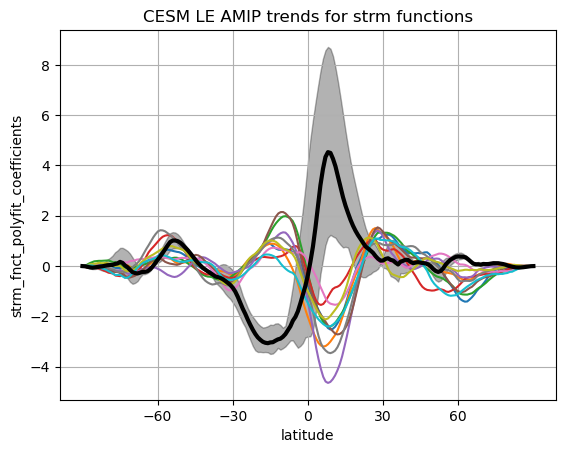

In [18]:
(cesm2_toga_amip_le_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest') / 1e8).plot.line(x='latitude', add_legend=False)
#(cesm2_amip_le_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest') / 1e8).plot.line(x='latitude', add_legend=False)
#(cesm2_le_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest') / 1e8).plot.line(x='latitude', add_legend=False)
#(hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=50000, method='nearest') / 1e8).plot.line(x='latitude', add_legend=False)
#(amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=50000, method='nearest') / 1e8).plot.line(x='latitude', add_legend=False)

(reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest').mean('model') / 1e8).plot(color='k', lw=3)
plt.fill_between(lats,
                 (reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest').min('model')) / 1e8,
                 (reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1).sel(level=500, method='nearest').max('model'))/ 1e8,
                 color='k', alpha=0.3)
            
plt.xticks([-60, -30, 0, 30, 60])
#plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.title(f'CESM LE AMIP trends for strm functions')
plt.grid()
plt.show()

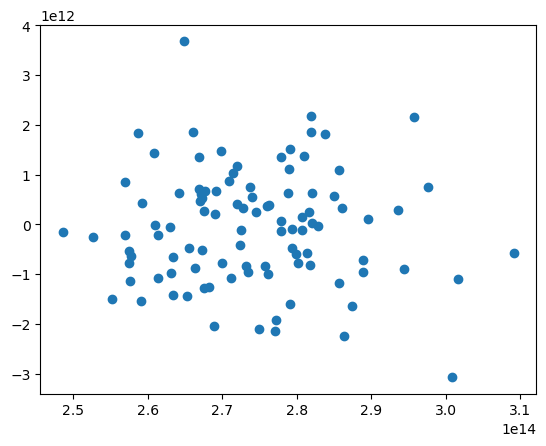

In [19]:
field = 'se_aht'
which_lat = 75


plt.scatter(cesm2_le_ds[field].sel(latitude=which_lat, method='nearest').mean('time'),
            cesm2_le_trends[field + '_polyfit_coefficients'].sel(latitude=which_lat, method='nearest').sel(degree=1))

plt.show()

In [20]:
def trend_err(field):
    
    uncertainty = []

    try:
        for i in range(len(field.model)):

            one_uncertainty = np.sqrt(np.diag(field.isel(model=i)))[0]
            uncertainty.append(one_uncertainty)
    except AttributeError:
        one_uncertainty = np.sqrt(np.diag(field))[0]
        uncertainty.append(one_uncertainty)

    uncertainty = np.array(uncertainty) * 40 / 1e15
    
    return uncertainty

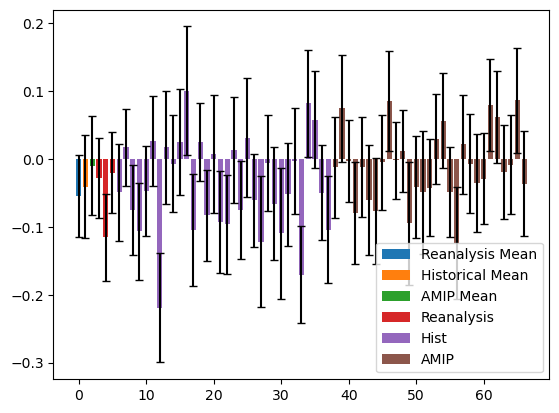

In [21]:
field = 'te_aht_dry_pot_polyfit_coefficients'
field_err = 'te_aht_dry_pot_polyfit_covariance'
which_lat = slice(40, 70)

plt.bar(range(1),
        40 / 1e15 * reanalysis_trends[field].sel(latitude=which_lat).mean('latitude').sel(degree=1).mean('model'),
        yerr=trend_err(reanalysis_trends[field_err].mean('model').sel(latitude=which_lat).mean('latitude')),
        capsize=3, label='Reanalysis Mean')

plt.bar(range(1,2),
        40 / 1e15 * hist_trends[field].sel(latitude=which_lat).mean('latitude').sel(degree=1).mean('model'),
        yerr=trend_err(hist_trends[field_err].mean('model').sel(latitude=which_lat).mean('latitude')),
        capsize=3, label='Historical Mean')
plt.bar(range(2,3),
        40 / 1e15 * amip_trends[field].sel(latitude=which_lat).mean('latitude').sel(degree=1).mean('model'),
        yerr=trend_err(amip_trends[field_err].mean('model').sel(latitude=which_lat).mean('latitude')),
        capsize=3,label='AMIP Mean')

plt.bar(range(3,6),
        40 / 1e15 * reanalysis_trends[field].sel(latitude=which_lat).mean('latitude').sel(degree=1),
        yerr=trend_err(reanalysis_trends[field_err].sel(latitude=which_lat,).mean('latitude')), capsize=3,
                       label='Reanalysis')

plt.bar(range(6, len(hist_trends.model) + 6),
        40 / 1e15 * hist_trends[field].sel(latitude=which_lat).mean('latitude').sel(degree=1),
        yerr=trend_err(hist_trends[field_err].sel(latitude=which_lat).mean('latitude')), capsize=3,
        label='Hist')

plt.bar(range(6 + len(hist_trends.model), len(amip_trends.model) + len(hist_trends.model) + 6),
        40 / 1e15 * amip_trends[field].sel(latitude=which_lat).mean('latitude').sel(degree=1),
        yerr=trend_err(amip_trends[field_err].sel(latitude=which_lat).mean('latitude')), capsize=3,
        label='AMIP')


plt.legend(loc=0)
plt.show()

In [ ]:
#fig, axs = plt.subplots(3, 2,  figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1, 1]})

#fig, axes = plt.subplot_mosaic("AA;BC;DE")
#x = [['A panel', 'A panel', 'edge'],
     #['C panel', '.',       'edge']]

panel_order = [['A', 'A'], ['B', 'C'], ['D', 'E']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70

ylims = [-0.4, 0.4]

axs['A'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['A'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['A'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['A'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_le_color)
#axs['A'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.total_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['A'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.total_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['A'].set_ylim(ylims)
axs['A'].grid()
#axs['A'].axvline(vline1)
#axs['A'].axvline(vline2)
axs['A'].set_title('Total AHT trends')

axs['B'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['B'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['B'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['B'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.mmc_aht_dry_pot_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_le_color)
#axs['B'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_amip_color)
#axs['B'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_toga_amip_color)
axs['B'].set_ylim(ylims)
axs['B'].grid()
#axs['B'].axvline(vline1)
#axs['B'].axvline(vline2)
axs['B'].set_title('MMC AHT trends')

axs['C'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.eddy_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['C'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.eddy_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['C'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.eddy_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['C'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.eddy_aht_dry_pot_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_le_color)
#axs['C'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['C'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['C'].set_ylim(ylims)
axs['C'].grid()
#axs['C'].axvline(vline1)
#axs['C'].axvline(vline2)
axs['C'].set_title('Eddy AHT trends')

axs['D'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['D'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['D'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['D'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.te_aht_dry_pot_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_le_color)
#axs['D'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['D'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['D'].set_ylim(ylims)
axs['D'].grid()
#axs['D'].axvline(vline1)
#axs['D'].axvline(vline2)
axs['D'].set_title('TE AHT trends')

axs['E'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color, label='Reanalysis')
axs['E'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color, label='Historical')
axs['E'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color, label='AMIP')
#axs['E'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.se_aht_dry_pot_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_le_color, label='CESM2 LE')
#axs['E'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color, label='CESM AMIP')
#axs['E'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color, label='CESM TOGA AMIP')
axs['E'].set_ylim(ylims)
axs['E'].grid()
#axs['E'].axvline(vline1)
#axs['E'].axvline(vline2)
axs['E'].set_title('SE AHT trends')
axs['E'].legend(loc=[1,1])

fig.tight_layout()

#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_amip_hist_dry_pot_trends')
#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_cesm_amip_cesm_le_dry_pot_trends')
#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_cesm_amip_cesm_toga_full_trends')
plt.show()

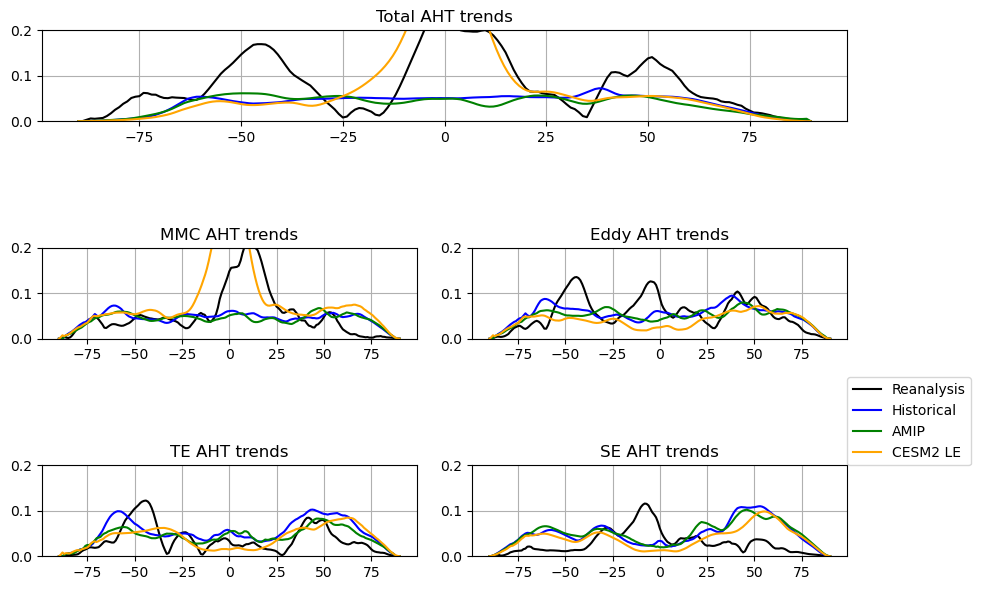

In [23]:
#fig, axs = plt.subplots(3, 2,  figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1, 1]})

#fig, axes = plt.subplot_mosaic("AA;BC;DE")
#x = [['A panel', 'A panel', 'edge'],
     #['C panel', '.',       'edge']]

panel_order = [['A', 'A'], ['B', 'C'], ['D', 'E']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70

axs['A'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.total_aht_polyfit_coefficients.sel(degree=1).std('model'), color=reanalysis_color)
axs['A'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.total_aht_polyfit_coefficients.sel(degree=1).std('model'), color=hist_color)
axs['A'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.total_aht_polyfit_coefficients.sel(degree=1).std('model'), color=amip_color)
axs['A'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=cesm2_le_color)
#axs['A'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.total_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['A'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.total_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['A'].set_ylim([0, 0.2])
axs['A'].grid()
#axs['A'].axvline(vline1)
#axs['A'].axvline(vline2)
axs['A'].set_title('Total AHT trends')

axs['B'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).std('model'), color=reanalysis_color)
axs['B'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).std('model'), color=hist_color)
axs['B'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).std('model'), color=amip_color)
axs['B'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.mmc_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=cesm2_le_color)
#axs['B'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_amip_color)
#axs['B'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_toga_amip_color)
axs['B'].set_ylim([0, 0.2])
axs['B'].grid()
#axs['B'].axvline(vline1)
#axs['B'].axvline(vline2)
axs['B'].set_title('MMC AHT trends')

axs['C'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.eddy_aht_polyfit_coefficients.sel(degree=1).std('model'), color=reanalysis_color)
axs['C'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.eddy_aht_polyfit_coefficients.sel(degree=1).std('model'), color=hist_color)
axs['C'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.eddy_aht_polyfit_coefficients.sel(degree=1).std('model'), color=amip_color)
axs['C'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.eddy_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=cesm2_le_color)
#axs['C'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['C'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['C'].set_ylim([0, 0.2])
axs['C'].grid()
#axs['C'].axvline(vline1)
#axs['C'].axvline(vline2)
axs['C'].set_title('Eddy AHT trends')

axs['D'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.te_aht_polyfit_coefficients.sel(degree=1).std('model'), color=reanalysis_color)
axs['D'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.te_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=hist_color)
axs['D'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.te_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=amip_color)
axs['D'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.te_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=cesm2_le_color)
#axs['D'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['D'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['D'].set_ylim([0, 0.2])
axs['D'].grid()
#axs['D'].axvline(vline1)
#axs['D'].axvline(vline2)
axs['D'].set_title('TE AHT trends')

axs['E'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1).std('model'), color=reanalysis_color, label='Reanalysis')
axs['E'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.se_aht_polyfit_coefficients.sel(degree=1).std('model'), color=hist_color, label='Historical')
axs['E'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.se_aht_polyfit_coefficients.sel(degree=1).std('model'), color=amip_color, label='AMIP')
axs['E'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.se_aht_dry_pot_polyfit_coefficients.sel(degree=1).std('model'), color=cesm2_le_color, label='CESM2 LE')
#axs['E'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color, label='CESM AMIP')
#axs['E'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color, label='CESM TOGA AMIP')
axs['E'].set_ylim([0, 0.2])
axs['E'].grid()
#axs['E'].axvline(vline1)
#axs['E'].axvline(vline2)
axs['E'].set_title('SE AHT trends')
axs['E'].legend(loc=[1,1])

fig.tight_layout()

#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_amip_hist_dry_pot_trends')
#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_cesm_amip_cesm_le_dry_pot_trends')
#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_cesm_amip_cesm_toga_full_trends')
plt.show()

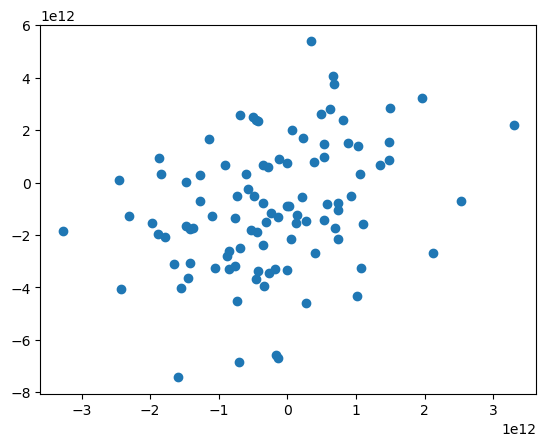

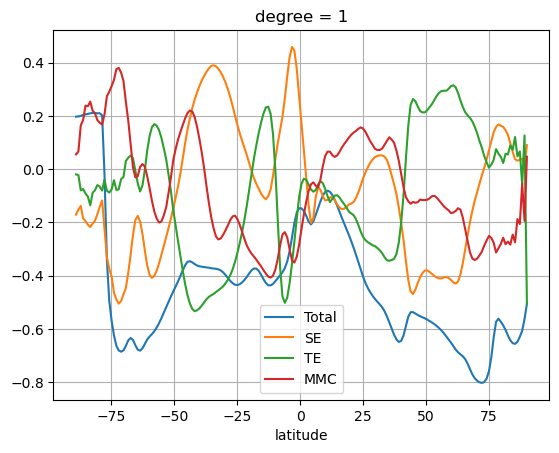

In [24]:
ocean_lat = -30
se_lat = -30

plt.scatter(cesm2_le_trends.total_oht_polyfit_coefficients.sel(degree=1).sel(latitude=ocean_lat, method='nearest'),
            cesm2_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=se_lat, method='nearest'))

plt.show()

ocean_total_corr = xr.corr(cesm2_le_trends.total_oht_polyfit_coefficients.sel(degree=1),
                        cesm2_le_trends.total_aht_polyfit_coefficients.sel(degree=1), dim='model')
ocean_se_corr = xr.corr(cesm2_le_trends.total_oht_polyfit_coefficients.sel(degree=1),
                        cesm2_le_trends.se_aht_polyfit_coefficients.sel(degree=1), dim='model')
ocean_te_corr = xr.corr(cesm2_le_trends.total_oht_polyfit_coefficients.sel(degree=1),
                        cesm2_le_trends.te_aht_polyfit_coefficients.sel(degree=1), dim='model')
ocean_mmc_corr = xr.corr(cesm2_le_trends.total_oht_polyfit_coefficients.sel(degree=1),
                        cesm2_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1), dim='model')

ocean_total_corr.plot(label='Total')
ocean_se_corr.plot(label='SE')
ocean_te_corr.plot(label='TE')
ocean_mmc_corr.plot(label='MMC')
plt.legend(loc=0)
plt.grid()
plt.show()
            
            

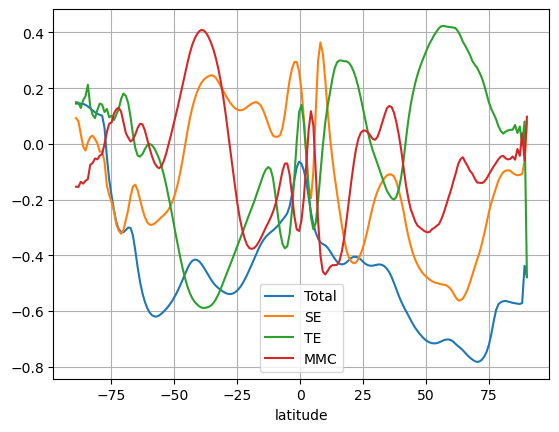

In [25]:
cesm2_le_year = cesm2_le_ds.groupby('time.year').mean('time')

ocean_total_corr = xr.corr(cesm2_le_year.total_oht,
                        cesm2_le_year.total_aht, dim='year')
ocean_se_corr = xr.corr(cesm2_le_year.total_oht,
                        cesm2_le_year.se_aht, dim='year')
ocean_te_corr = xr.corr(cesm2_le_year.total_oht,
                        cesm2_le_year.te_aht, dim='year')
ocean_mmc_corr = xr.corr(cesm2_le_year.total_oht,
                        cesm2_le_year.mmc_aht, dim='year')

ocean_total_corr.mean('model').plot(label='Total')
ocean_se_corr.mean('model').plot(label='SE')
ocean_te_corr.mean('model').plot(label='TE')
ocean_mmc_corr.mean('model').plot(label='MMC')
plt.legend(loc=0)
plt.grid()
plt.show()

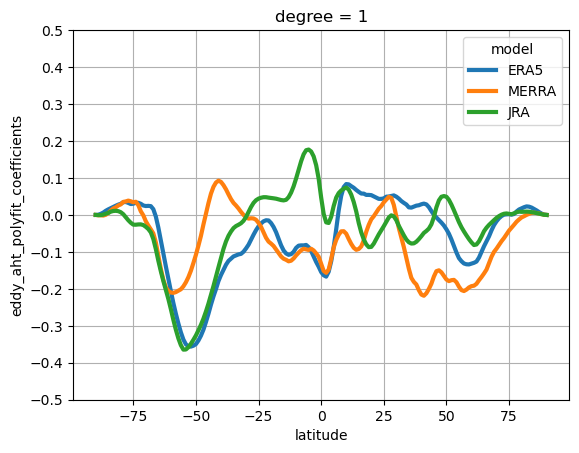

In [26]:
(40 * reanalysis_trends['eddy_aht_polyfit_coefficients'].sel(degree=1) / 1e15).plot.line(x='latitude', lw=3)

#plt.xticks([-60, -30, 0, 30, 60])
plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5])
plt.grid()
plt.show()

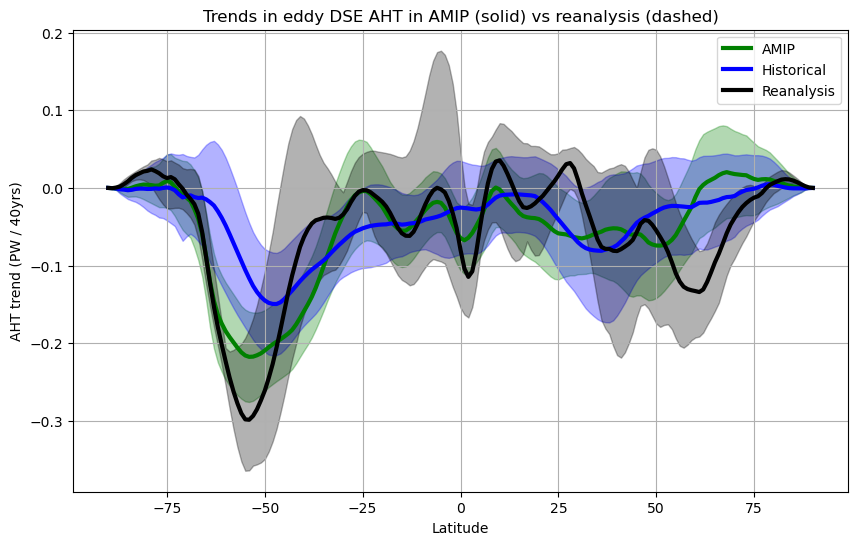

In [27]:
field = 'eddy_aht_polyfit_coefficients'
plt.figure(figsize=(10,6))


plt.fill_between(lats,
                 (amip_trends[field].mean('model') + amip_trends[field].std('model')).sel(degree=1) * 40 / 1e15,
                 (amip_trends[field].mean('model') - amip_trends[field].std('model')).sel(degree=1) * 40 / 1e15,
                 color='g', alpha=0.3)


plt.fill_between(lats,
                 (hist_trends[field].mean('model') + hist_trends[field].std('model')).sel(degree=1) * 40 / 1e15,
                 (hist_trends[field].mean('model') - hist_trends[field].std('model')).sel(degree=1) * 40 / 1e15,
                 color='b', alpha=0.3)

#plt.fill_between(lats,
                 #(reanalysis_trends[field].mean('model') + reanalysis_trends[field].std('model')).sel(degree=1) * 40 / 1e15,
                 #(reanalysis_trends[field].mean('model') - reanalysis_trends[field].std('model')).sel(degree=1) * 40 / 1e15,
                 #color='k', alpha=0.3)

plt.fill_between(lats,
                 (reanalysis_trends[field].min('model')).sel(degree=1) * 40 / 1e15,
                 (reanalysis_trends[field].max('model')).sel(degree=1) * 40 / 1e15,
                 color='k', alpha=0.3)

plt.plot(lats, 40 * amip_trends[field].mean('model').sel(degree=1)/ 1e15, '-', lw=3, color='g', label='AMIP')
plt.plot(lats, 40 * hist_trends[field].mean('model').sel(degree=1)/ 1e15, '-', lw=3,color='b', label='Historical')
plt.plot(lats, 40 * reanalysis_trends[field].mean('model').sel(degree=1)/ 1e15, '-', lw=3,color='k', label='Reanalysis')



plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT trend (PW / 40yrs)')
plt.title('Trends in eddy DSE AHT in AMIP (solid) vs reanalysis (dashed)')
#plt.savefig('../figures/Dec_22/eddy_aht_dry_pot_reanalysis_amip_historical_trends')

plt.show()

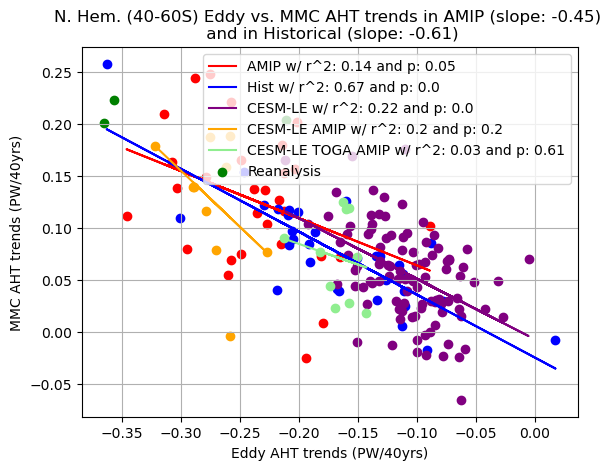

In [75]:
lat_slice = slice(-60, -40)
multiplier = 40 / 1e15

eddy_trends_amip = amip_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
eddy_trends_idxs_amip = amip_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
mmc_trends_amip = amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=eddy_trends_idxs_amip) * multiplier


eddy_trends_hist = hist_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
eddy_trends_idxs_hist = hist_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
mmc_trends_hist = hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=eddy_trends_idxs_hist) * multiplier

eddy_trends_reanalysis = reanalysis_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
eddy_trends_idxs_reanalysis = reanalysis_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
mmc_trends_reanalysis = reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=eddy_trends_idxs_reanalysis) * multiplier

eddy_trends_cesm_le = cesm2_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
eddy_trends_idxs_cesm_le = cesm2_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
mmc_trends_cesm_le = cesm2_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=eddy_trends_idxs_cesm_le) * multiplier

eddy_trends_cesm_amip_le = cesm2_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
eddy_trends_idxs_cesm_amip_le = cesm2_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
mmc_trends_cesm_amip_le = cesm2_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=eddy_trends_idxs_cesm_amip_le) * multiplier

eddy_trends_cesm_toga_amip_le = cesm2_toga_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
eddy_trends_idxs_cesm_toga_amip_le = cesm2_toga_amip_le_trends.eddy_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
mmc_trends_cesm_toga_amip_le = cesm2_toga_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=eddy_trends_idxs_cesm_amip_le) * multiplier


plt.scatter(eddy_trends_amip, mmc_trends_amip, color='r')
amip_linregress = linregress(eddy_trends_amip, mmc_trends_amip)
slope_amip = amip_linregress.slope
int_amip = amip_linregress.intercept
r_amip = amip_linregress.rvalue
p_amip = amip_linregress.pvalue
plt.plot(eddy_trends_amip, slope_amip * eddy_trends_amip + int_amip, color='r', label=f'AMIP w/ r^2: {round(r_amip**2, 2)} and p: {round(p_amip, 2)}')

plt.scatter(eddy_trends_hist, mmc_trends_hist, color='b')
hist_linregress = linregress(eddy_trends_hist, mmc_trends_hist)
slope_hist = hist_linregress.slope
int_hist = hist_linregress.intercept
r_hist = hist_linregress.rvalue
p_hist = hist_linregress.pvalue
plt.plot(eddy_trends_hist, slope_hist * eddy_trends_hist + int_hist, color='b', label=f'Hist w/ r^2: {round(r_hist**2, 2)} and p: {round(p_hist, 2)}')

plt.scatter(eddy_trends_cesm_le, mmc_trends_cesm_le, color='purple')
cesm_le_linregress = linregress(eddy_trends_cesm_le, mmc_trends_cesm_le)
slope_cesm_le = cesm_le_linregress.slope
int_cesm_le = cesm_le_linregress.intercept
r_cesm_le = cesm_le_linregress.rvalue
p_cesm_le = cesm_le_linregress.pvalue
plt.plot(eddy_trends_cesm_le, slope_cesm_le * eddy_trends_cesm_le + int_cesm_le, color='purple',
         label=f'CESM-LE w/ r^2: {round(r_cesm_le**2, 2)} and p: {round(p_cesm_le, 2)}')

plt.scatter(eddy_trends_cesm_amip_le, mmc_trends_cesm_amip_le, color='orange')
cesm_amip_le_linregress = linregress(eddy_trends_cesm_amip_le, mmc_trends_cesm_amip_le)
slope_cesm_amip_le = cesm_amip_le_linregress.slope
int_cesm_amip_le = cesm_amip_le_linregress.intercept
r_cesm_amip_le = cesm_amip_le_linregress.rvalue
p_cesm_amip_le = cesm_amip_le_linregress.pvalue
plt.plot(eddy_trends_cesm_amip_le, slope_cesm_amip_le * eddy_trends_cesm_amip_le + int_cesm_amip_le, color='orange',
         label=f'CESM-LE AMIP w/ r^2: {round(r_cesm_amip_le**2, 2)} and p: {round(p_cesm_amip_le, 2)}')

plt.scatter(eddy_trends_cesm_toga_amip_le, mmc_trends_cesm_toga_amip_le, color='lightgreen')
cesm_toga_amip_le_linregress = linregress(eddy_trends_cesm_toga_amip_le, mmc_trends_cesm_toga_amip_le)
slope_cesm_toga_amip_le = cesm_toga_amip_le_linregress.slope
int_cesm_toga_amip_le = cesm_toga_amip_le_linregress.intercept
r_cesm_toga_amip_le = cesm_toga_amip_le_linregress.rvalue
p_cesm_toga_amip_le = cesm_toga_amip_le_linregress.pvalue
plt.plot(eddy_trends_cesm_toga_amip_le, slope_cesm_toga_amip_le * eddy_trends_cesm_toga_amip_le + int_cesm_toga_amip_le, color='lightgreen',
         label=f'CESM-LE TOGA AMIP w/ r^2: {round(r_cesm_toga_amip_le**2, 2)} and p: {round(p_cesm_toga_amip_le, 2)}')


plt.scatter(eddy_trends_reanalysis, mmc_trends_reanalysis, color='g', label='Reanalysis')

#plt.gca().invert_xaxis()

#plt.plot(np.linspace(-.4, 0, 50), -np.linspace(-.4, 0, 50),  color='k')

plt.legend(loc=0)

plt.title(f'N. Hem. (40-60S) Eddy vs. MMC AHT trends in AMIP (slope: {round(slope_amip, 2)}) \n and in Historical (slope: {round(slope_hist, 2)})')

#plt.title(f'N. Hem. (50-75N) Eddy vs. MMC AHT trends in AMIP (slope: {round(slope_amip, 2)}) \n and in Historical (slope: {round(slope_hist, 2)})')
plt.xlabel('Eddy AHT trends (PW/40yrs)')
plt.ylabel('MMC AHT trends (PW/40yrs)')
plt.grid()
#plt.savefig('../figures/1_20_23_meeting/mmc_eddy_compensation_scatter_n_hem_50_75N')
plt.show()


In [29]:
#cesm2_le_ds_anom = cesm2_le_ds_full - cesm2_le_ds_full.mean('time')
cesm2_full_year = cesm2_le_ds_full.sel(time=slice('1951-01-01','2014-12-31')).groupby('time.year').mean('time')

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

cesm2_le_ds_anom = cesm2_full_year - cesm2_full_year.mean('year')
#cesm2_le_ds_anom = detrend_dim(cesm2_full_year, 'year')

In [30]:
multiplier = 1 / 1e15
#lat_slice = slice(-70, -40)
lat_slice = slice(40, 70)

eddy_month_anom = cesm2_le_ds_anom.eddy_aht.sel(latitude=lat_slice).min('latitude') * multiplier
eddy_month_anom_idxs = cesm2_le_ds_anom.eddy_aht.sel(latitude=lat_slice).argmin('latitude')
mmc_month_anom = cesm2_le_ds_anom.mmc_aht.sel(latitude=lat_slice).isel(latitude=eddy_month_anom_idxs) * multiplier


In [31]:
eddy_month_anom = eddy_month_anom.values.flatten()
mmc_month_anom = mmc_month_anom.values.flatten()

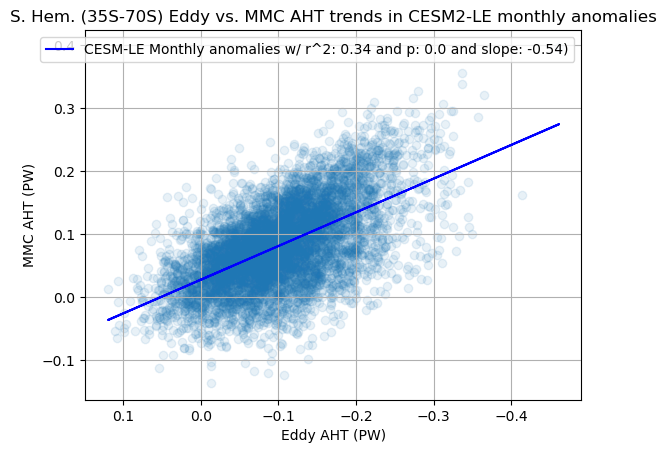

In [74]:
plt.scatter(eddy_month_anom, mmc_month_anom, alpha=0.1)
cesm_month_linregress = linregress(eddy_month_anom, mmc_month_anom)
slope_cesm_month = cesm_month_linregress.slope
int_cesm_month = cesm_month_linregress.intercept
r_cesm_month = cesm_month_linregress.rvalue
p_cesm_month = cesm_month_linregress.pvalue
plt.plot(eddy_month_anom, slope_cesm_month * eddy_month_anom + int_cesm_month, color='blue',
         label=f'CESM-LE Monthly anomalies w/ r^2: {round(r_cesm_month**2, 2)} and p: {round(p_cesm_month, 2)} and slope: {round(slope_cesm_month, 2)})')

plt.gca().invert_xaxis()

#plt.plot(np.linspace(np.amin(eddy_month_anom), np.amax(eddy_month_anom), 50), -np.linspace(np.amin(eddy_month_anom), np.amax(eddy_month_anom), 50),  '--', color='k')

plt.legend(loc=0)

plt.title(f'S. Hem. (35S-70S) Eddy vs. MMC AHT trends in CESM2-LE monthly anomalies')
plt.xlabel('Eddy AHT (PW)')
plt.ylabel('MMC AHT (PW)')
plt.grid()
#plt.savefig('../figures/Dec_22/mmc_eddy_compensation_amip_historical_reanalysis')#_aaron_style')
plt.show()

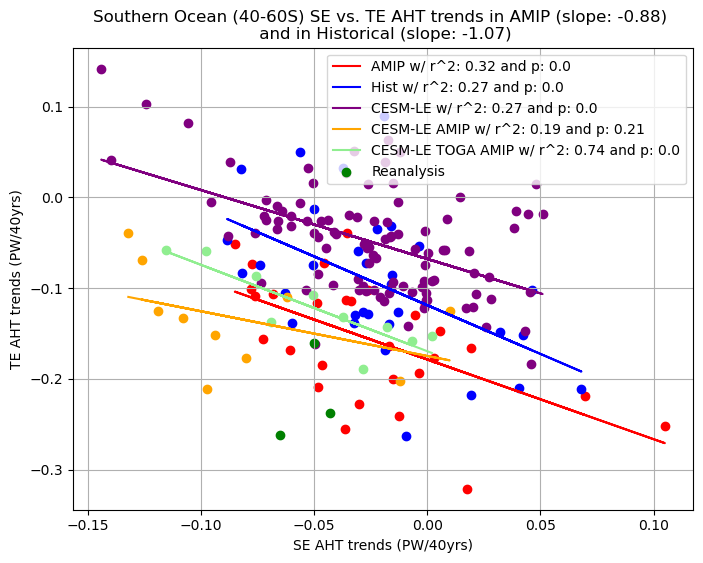

In [72]:
lat_slice = slice(-60, -40)
multiplier = 40 / 1e15

plt.figure(figsize=(8,6))

se_trends_amip = amip_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
se_trends_idxs_amip = amip_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
te_trends_amip = amip_trends.te_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=se_trends_idxs_amip) * multiplier


se_trends_hist = hist_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
se_trends_idxs_hist = hist_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
te_trends_hist = hist_trends.te_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=se_trends_idxs_hist) * multiplier

se_trends_reanalysis = reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
se_trends_idxs_reanalysis = reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
te_trends_reanalysis = reanalysis_trends.te_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=se_trends_idxs_reanalysis) * multiplier

se_trends_cesm_le = cesm2_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
se_trends_idxs_cesm_le = cesm2_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
te_trends_cesm_le = cesm2_le_trends.te_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=se_trends_idxs_cesm_le) * multiplier

se_trends_cesm_amip_le = cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
se_trends_idxs_cesm_amip_le = cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
te_trends_cesm_amip_le = cesm2_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=se_trends_idxs_cesm_amip_le) * multiplier

se_trends_cesm_toga_amip_le = cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).min('latitude') * multiplier
se_trends_idxs_cesm_toga_amip_le = cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).argmin('latitude')
te_trends_cesm_toga_amip_le = cesm2_toga_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).sel(latitude=lat_slice).isel(latitude=se_trends_idxs_cesm_amip_le) * multiplier


plt.scatter(se_trends_amip, te_trends_amip, color='r')
amip_linregress = linregress(se_trends_amip, te_trends_amip)
slope_amip = amip_linregress.slope
int_amip = amip_linregress.intercept
r_amip = amip_linregress.rvalue
p_amip = amip_linregress.pvalue
plt.plot(se_trends_amip, slope_amip * se_trends_amip + int_amip, color='r', label=f'AMIP w/ r^2: {round(r_amip**2, 2)} and p: {round(p_amip, 2)}')

plt.scatter(se_trends_hist, te_trends_hist, color='b')
hist_linregress = linregress(se_trends_hist, te_trends_hist)
slope_hist = hist_linregress.slope
int_hist = hist_linregress.intercept
r_hist = hist_linregress.rvalue
p_hist = hist_linregress.pvalue
plt.plot(se_trends_hist, slope_hist * se_trends_hist + int_hist, color='b', label=f'Hist w/ r^2: {round(r_hist**2, 2)} and p: {round(p_hist, 2)}')

plt.scatter(se_trends_cesm_le, te_trends_cesm_le, color='purple')
cesm_le_linregress = linregress(se_trends_cesm_le, te_trends_cesm_le)
slope_cesm_le = cesm_le_linregress.slope
int_cesm_le = cesm_le_linregress.intercept
r_cesm_le = cesm_le_linregress.rvalue
p_cesm_le = cesm_le_linregress.pvalue
plt.plot(se_trends_cesm_le, slope_cesm_le * se_trends_cesm_le + int_cesm_le, color='purple',
         label=f'CESM-LE w/ r^2: {round(r_cesm_le**2, 2)} and p: {round(p_cesm_le, 2)}')

plt.scatter(se_trends_cesm_amip_le, te_trends_cesm_amip_le, color='orange')
cesm_amip_le_linregress = linregress(se_trends_cesm_amip_le, te_trends_cesm_amip_le)
slope_cesm_amip_le = cesm_amip_le_linregress.slope
int_cesm_amip_le = cesm_amip_le_linregress.intercept
r_cesm_amip_le = cesm_amip_le_linregress.rvalue
p_cesm_amip_le = cesm_amip_le_linregress.pvalue
plt.plot(se_trends_cesm_amip_le, slope_cesm_amip_le * se_trends_cesm_amip_le + int_cesm_amip_le, color='orange',
         label=f'CESM-LE AMIP w/ r^2: {round(r_cesm_amip_le**2, 2)} and p: {round(p_cesm_amip_le, 2)}')

plt.scatter(se_trends_cesm_toga_amip_le, te_trends_cesm_toga_amip_le, color='lightgreen')
cesm_toga_amip_le_linregress = linregress(se_trends_cesm_toga_amip_le, te_trends_cesm_toga_amip_le)
slope_cesm_toga_amip_le = cesm_toga_amip_le_linregress.slope
int_cesm_toga_amip_le = cesm_toga_amip_le_linregress.intercept
r_cesm_toga_amip_le = cesm_toga_amip_le_linregress.rvalue
p_cesm_toga_amip_le = cesm_toga_amip_le_linregress.pvalue
plt.plot(se_trends_cesm_toga_amip_le, slope_cesm_toga_amip_le * se_trends_cesm_toga_amip_le + int_cesm_toga_amip_le, color='lightgreen',
         label=f'CESM-LE TOGA AMIP w/ r^2: {round(r_cesm_toga_amip_le**2, 2)} and p: {round(p_cesm_toga_amip_le, 2)}')


plt.scatter(se_trends_reanalysis, te_trends_reanalysis, color='g', label='Reanalysis')

#plt.gca().invert_xaxis()

#plt.plot(np.linspace(-.15, .15, 50), -np.linspace(-.15, .15, 50),  '--', color='k')

plt.legend(loc=0)

plt.title(f'Southern Ocean (40-60S) SE vs. TE AHT trends in AMIP (slope: {round(slope_amip, 2)}) \n and in Historical (slope: {round(slope_hist, 2)})')
plt.xlabel('SE AHT trends (PW/40yrs)')
plt.ylabel('TE AHT trends (PW/40yrs)')
plt.grid()
#plt.savefig('../figures/1_20_23_meeting/se_te_scatter_40_60S')
plt.show()



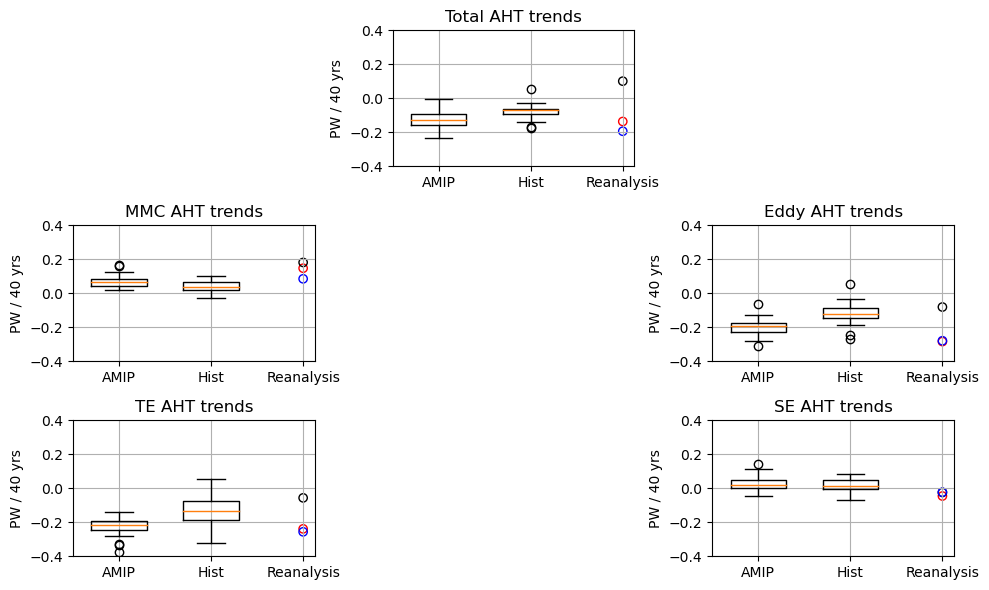

In [62]:
field1 = 'total_aht_polyfit_coefficients'
field2 = 'mmc_aht_polyfit_coefficients'
field3 = 'eddy_aht_polyfit_coefficients'
field4 = 'te_aht_polyfit_coefficients'
field5 = 'se_aht_polyfit_coefficients'
#which_lat = -60
lat_slice = slice(-60, -40)
#lat_slice = slice(49, 51)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['.', 'A', '.'], ['B', '.', 'C'], ['D', '.', 'E']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('Total AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('MMC AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['C'].set_title('Eddy AHT trends') 
#axs['C'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3])
axs['C'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['C'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['D'].set_title('TE AHT trends') 
#axs['D'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['D'].boxplot([amip_data, hist_data], widths=box_width)
axs['D'].set_xticks([1, 2, 3])
axs['D'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['D'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['D'].grid()
axs['D'].set_ylim(ylim)
axs['D'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['E'].set_title('SE AHT trends') 
#axs['E'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['E'].boxplot([amip_data, hist_data], widths=box_width)
axs['E'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['E'].set_xticks([1, 2, 3])
axs['E'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['E'].grid()
axs['E'].set_ylim(ylim)
axs['E'].set_ylabel('PW / 40 yrs')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_50N')
plt.show()

In [63]:
reanalysis_data

<xarray.DataArray 'se_aht_polyfit_coefficients' (model: 3)>
array([-0.04541034, -0.02446955, -0.02305332])
Coordinates:
    degree   int64 1
  * model    (model) object 'ERA5' 'MERRA' 'JRA'

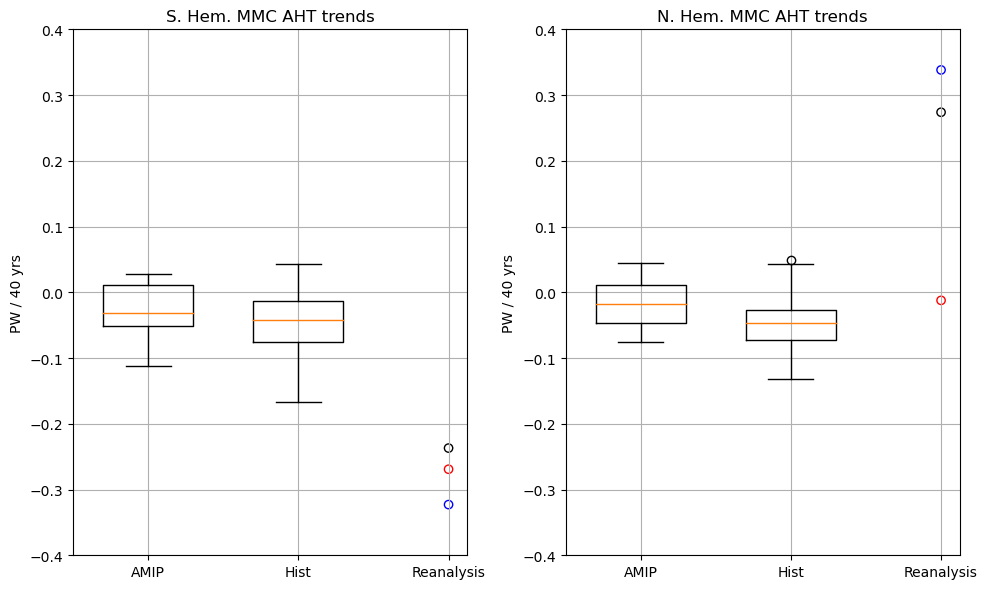

In [77]:
field = 'mmc_aht_polyfit_coefficients'
lat_slice1 = slice(-25, -10)
lat_slice2 = slice(10, 25)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('S. Hem. MMC AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('N. Hem. MMC AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_n_s_hem_mmc_aht')
plt.show()

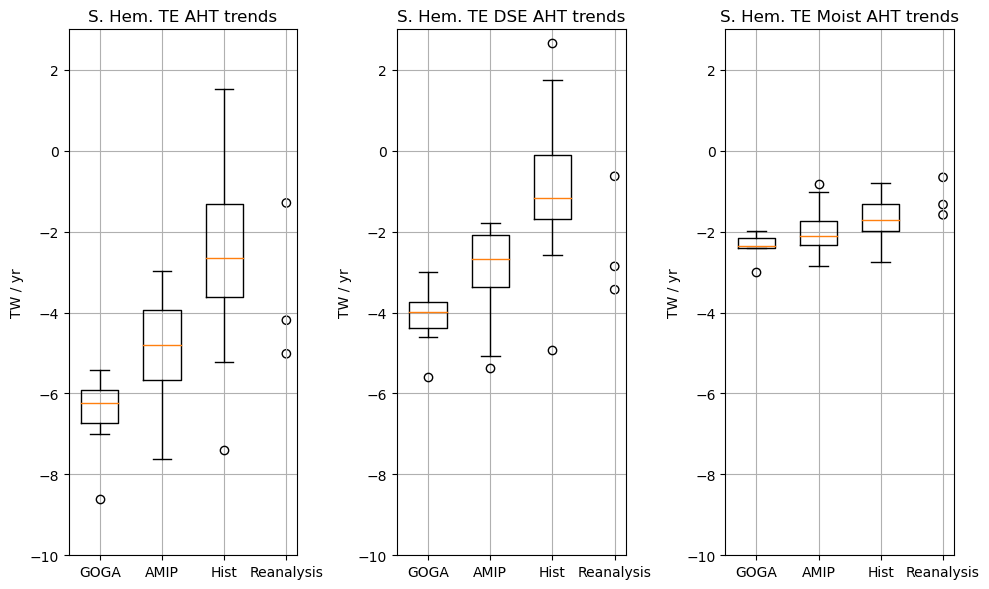

In [36]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'te_aht_dry_pot_polyfit_coefficients'
field3 = 'te_aht_moist_polyfit_coefficients'
lat_slice1 = slice(-70, -40)
ylim = [-10, 3]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B', 'C']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

goga_data = cesm2_amip_le_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
amip_data = amip_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
hist_data = hist_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12

axs['A'].set_title('S. Hem. TE AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3, 4])
axs['A'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
amip_data = amip_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
hist_data = hist_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12

axs['B'].set_title('S. Hem. TE DSE AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3, 4])
axs['B'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
amip_data = amip_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
hist_data = hist_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
reanalysis_data = reanalysis_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12

axs['C'].set_title('S. Hem. TE Moist AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3, 4])
axs['C'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['C'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('TW / yr')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_n_s_hem_mmc_aht')
plt.show()

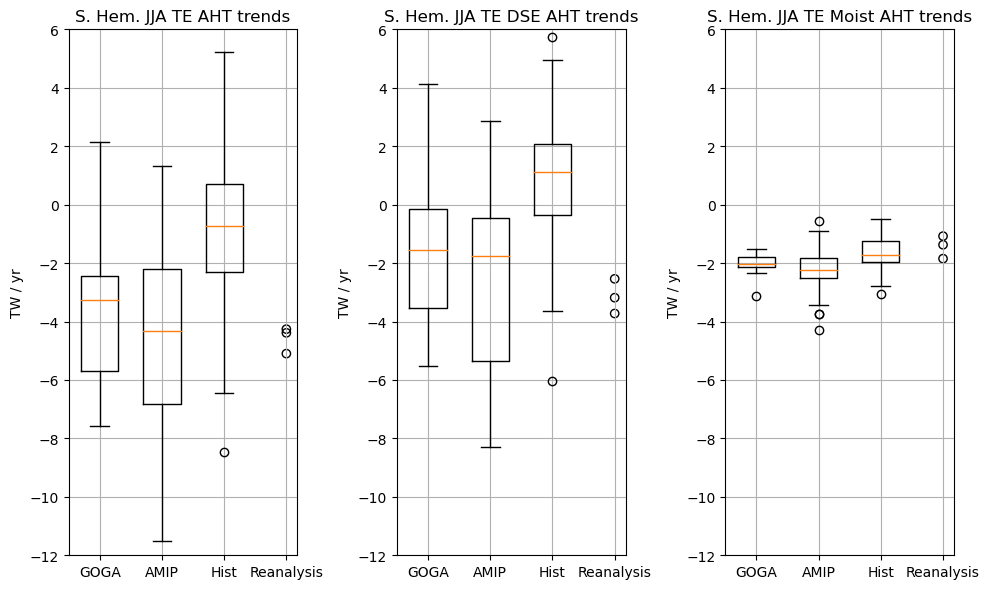

In [37]:
field1 = 'eddy_aht_polyfit_coefficients'
field2 = 'eddy_aht_dry_pot_polyfit_coefficients'
field3 = 'eddy_aht_moist_polyfit_coefficients'
lat_slice1 = slice(-70, -40)
ylim = [-12, 6]
which_months = [6, 7, 8]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B', 'C']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

goga_data = cesm2_amip_le_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
amip_data = amip_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
hist_data = hist_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
reanalysis_data = reanalysis_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12

axs['A'].set_title('S. Hem. JJA TE AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3, 4])
axs['A'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
amip_data = amip_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
hist_data = hist_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
reanalysis_data = reanalysis_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12

axs['B'].set_title('S. Hem. JJA TE DSE AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3, 4])
axs['B'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
amip_data = amip_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
hist_data = hist_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
reanalysis_data = reanalysis_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12

axs['C'].set_title('S. Hem. JJA TE Moist AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3, 4])
axs['C'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['C'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('TW / yr')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_n_s_hem_mmc_aht')
plt.show()

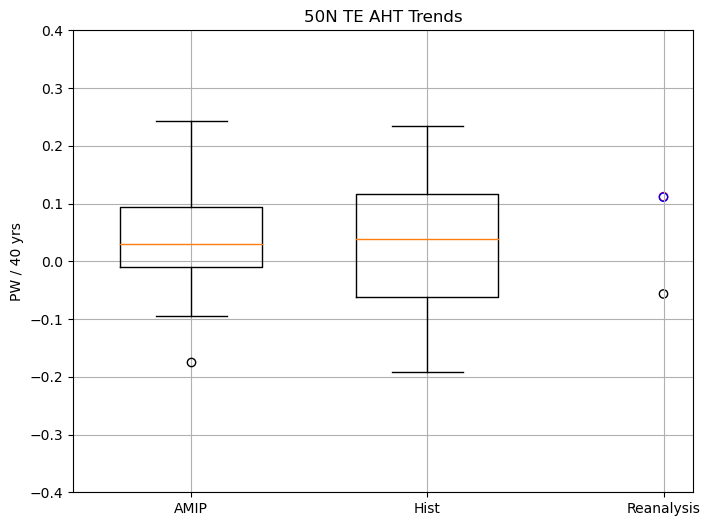

In [81]:
field = 'te_aht_polyfit_coefficients'
lat_slice1 = slice(49.5, 50.5)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
plt.figure(figsize=(8,6))


amip_data = amip_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

plt.title('50N TE AHT Trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
plt.boxplot([amip_data, hist_data], widths=box_width)
plt.xticks([1, 2, 3])
plt.gca().set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
plt.scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
plt.grid()
plt.ylim(ylim)
plt.ylabel('PW / 40 yrs')

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_50n_te_aht')
plt.show()

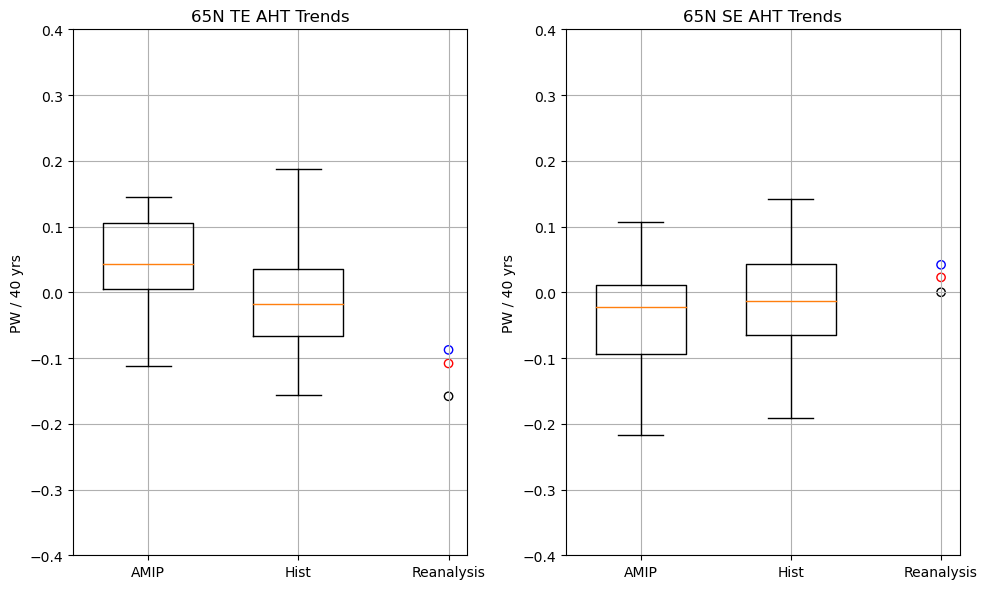

In [82]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'se_aht_polyfit_coefficients'
lat_slice = slice(64, 66)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('65N TE AHT Trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('65N SE AHT Trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_65n_te_se_aht')
plt.show()

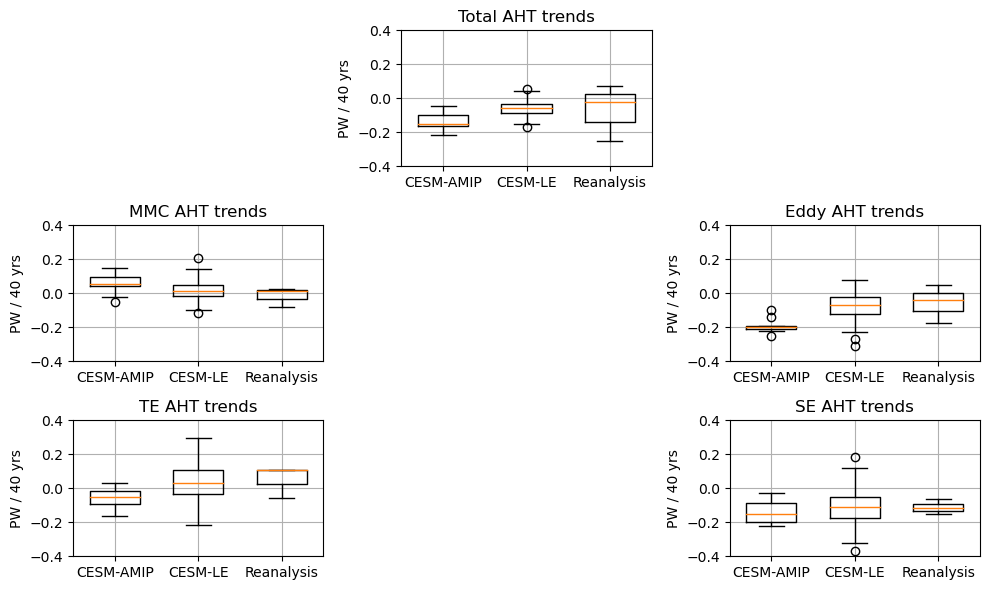

In [40]:
field1 = 'total_aht_polyfit_coefficients'
field2 = 'mmc_aht_polyfit_coefficients'
field3 = 'eddy_aht_polyfit_coefficients'
field4 = 'te_aht_polyfit_coefficients'
field5 = 'se_aht_polyfit_coefficients'
#which_lat = -60
lat_slice = slice(49, 51)
#lat_slice = slice(50, 70)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['.', 'A', '.'], ['B', '.', 'C'], ['D', '.', 'E']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = cesm2_amip_le_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('Total AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('MMC AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['C'].set_title('Eddy AHT trends') 
#axs['C'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3])
axs['C'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['D'].set_title('TE AHT trends') 
#axs['D'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['D'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['D'].set_xticks([1, 2, 3])
axs['D'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['D'].grid()
axs['D'].set_ylim(ylim)
axs['D'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['E'].set_title('SE AHT trends') 
#axs['E'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['E'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['E'].set_xticks([1, 2, 3])
axs['E'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['E'].grid()
axs['E'].set_ylim(ylim)
axs['E'].set_ylabel('PW / 40 yrs')

fig.tight_layout()

#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_cesm_amip_cesm_le_boxplots_60_45S_full_ahts')
plt.show()

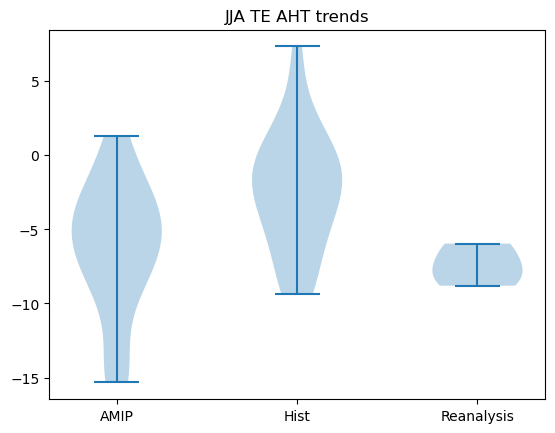

In [41]:

amip_data = amip_trends_month.eddy_aht_polyfit_coefficients.sel(latitude=slice(-51, -49)).mean(['latitude']).sel(degree=1).sel(month=[6, 7, 8]).mean('month')
hist_data = hist_trends_month.eddy_aht_polyfit_coefficients.sel(latitude=slice(-51, -49)).mean(['latitude']).sel(degree=1).sel(month=[6, 7, 8]).mean('month')
reanalysis_data = reanalysis_trends_month.eddy_aht_polyfit_coefficients.sel(latitude=slice(-51, -49)).mean(['latitude']).sel(degree=1).sel(month=[6, 7, 8]).mean('month')


plt.title('JJA TE AHT trends')
plt.violinplot([amip_data * 1000 / 40, hist_data * 1000 / 40, reanalysis_data * 1000 / 40])

plt.xticks([1, 2, 3], labels=['AMIP', 'Hist', 'Reanalysis'])

plt.show()

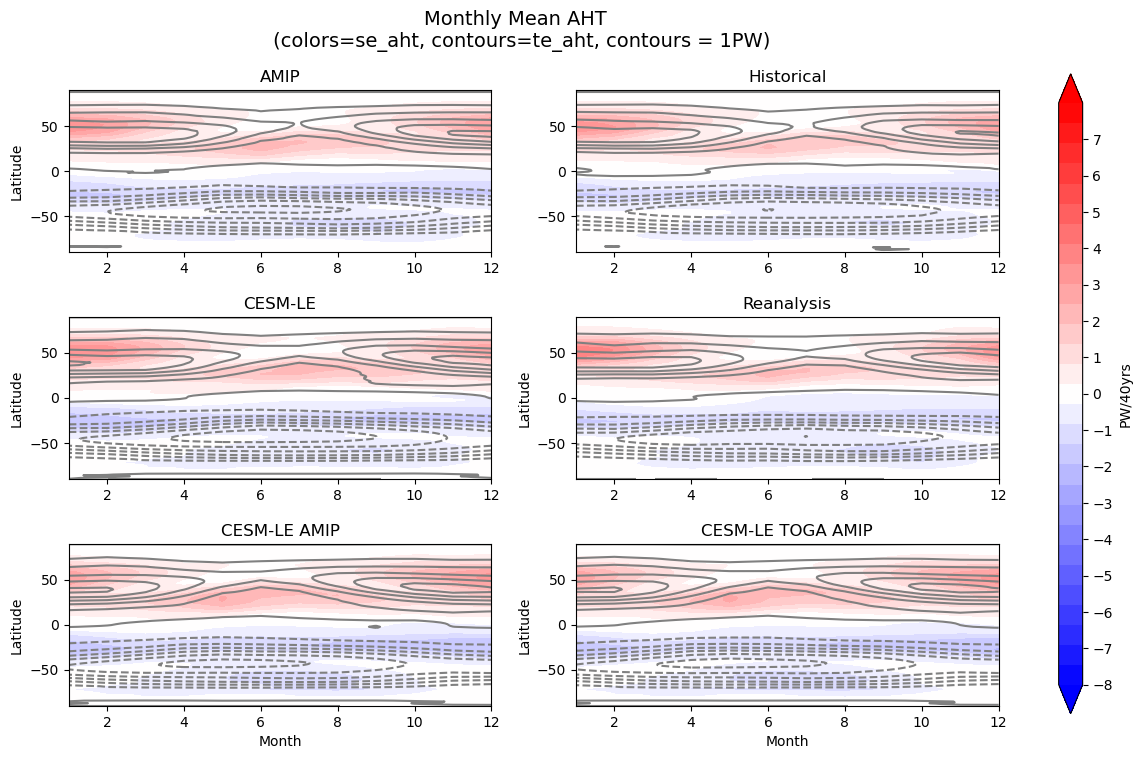

In [42]:
field1 = 'te_aht'
field2 = 'se_aht'

mmc_levels = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

eddy_levels = np.linspace(-8, 8, 30)

fig, axs = plt.subplots(3, 2,  figsize=(12, 8))

axs[0,0].contour(range(1,13), lats, amip_month[field1].median('model').T / 1e15,
             levels=mmc_levels,  colors='grey')

axs[0,0].contourf(range(1,13), lats, amip_month[field2].median('model').T / 1e15,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,0].set_title('AMIP')
#axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Latitude')

axs[0,1].contour(range(1,13), lats, hist_month[field1].median('model').T / 1e15,
             levels=mmc_levels,  colors='grey')

axs[0,1].contourf(range(1,13), lats, hist_month[field2].median('model').T / 1e15,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,1].set_title('Historical')
#axs[0,1].set_xlabel('Month')
#axs[0,1].set_ylabel('Latitude')


axs[1,1].contour(range(1,13), lats, reanalysis_month[field1].median('model').T / 1e15,
             levels=mmc_levels,  colors='grey')

contf = axs[1,1].contourf(range(1,13), lats, reanalysis_month[field2].median('model').T / 1e15,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[1,1].set_title('Reanalysis')
#axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Latitude')

axs[1,0].contour(range(1,13), cesm2_month.latitude, cesm2_month[field1].median('model').T / 1e15,
             levels=mmc_levels,  colors='grey')

contf = axs[1,0].contourf(range(1,13), cesm2_month.latitude, cesm2_month[field2].median('model').T / 1e15,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[1,0].set_title('CESM-LE')
#axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Latitude')

axs[2,0].contour(range(1,13), cesm2_amip_month.latitude, cesm2_amip_month[field1].median('model').T / 1e15,
             levels=mmc_levels,  colors='grey')

contf = axs[2,0].contourf(range(1,13), cesm2_amip_month.latitude, cesm2_amip_month[field2].median('model').T / 1e15,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[2,0].set_title('CESM-LE AMIP')
axs[2,0].set_xlabel('Month')
axs[2,0].set_ylabel('Latitude')

axs[2,1].contour(range(1,13), cesm2_toga_amip_month.latitude, cesm2_toga_amip_month[field1].median('model').T / 1e15,
             levels=mmc_levels,  colors='grey')

contf = axs[2,1].contourf(range(1,13), cesm2_toga_amip_month.latitude, cesm2_toga_amip_month[field2].median('model').T / 1e15,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[2,1].set_title('CESM-LE TOGA AMIP')
axs[2,1].set_xlabel('Month')
axs[2,1].set_ylabel('Latitude')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(contf, cax=cbar_ax, ticks=np.arange(-8, 8, 1), label='PW/40yrs')

fig.suptitle(f'Monthly Mean AHT \n (colors={field2}, contours={field1}, contours = 1PW)',fontsize=14)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

#plt.savefig('../figures/aht_trends_paper_initials/monthly_eddy_moist_dry_trends_reanalysis_amip_historical')
plt.show()

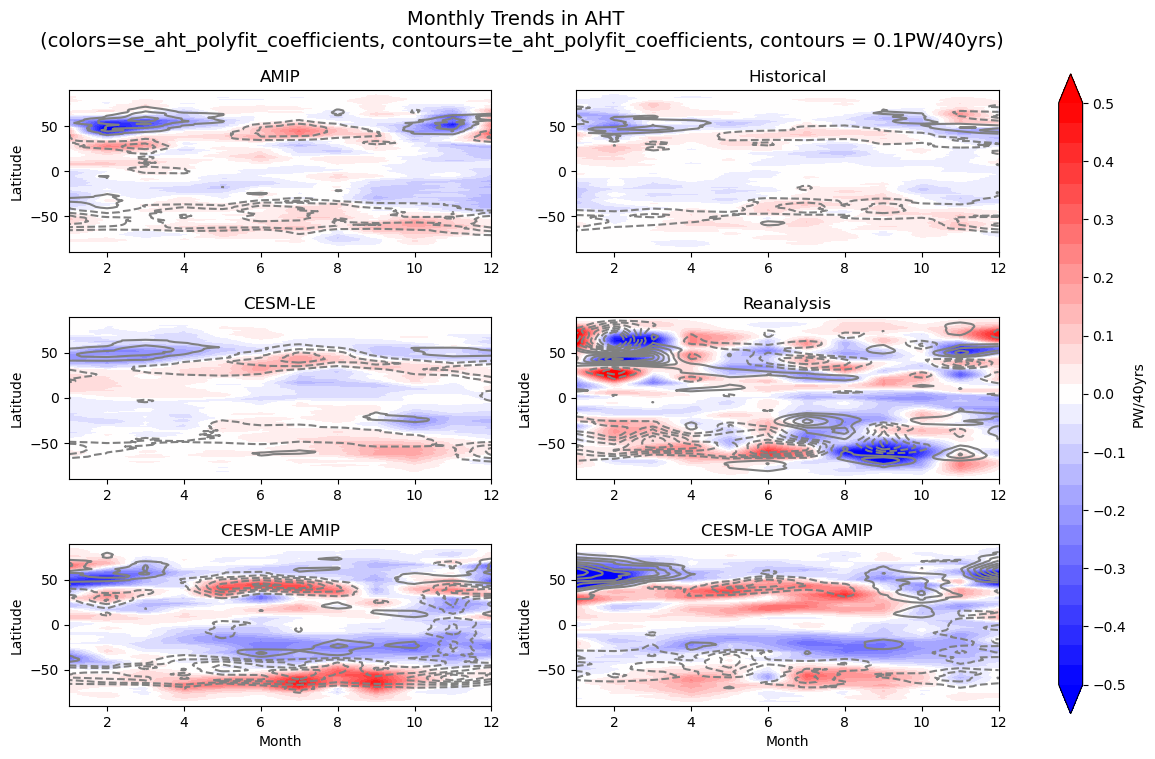

In [43]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'se_aht_polyfit_coefficients'

mmc_levels = [-0.7, -0.6, -0.5, -.4, -.3, -0.2, -0.1, 0.1, 0.2, .3, .4, .5, .6, .7]

eddy_levels = np.linspace(-0.5, 0.5, 30)

fig, axs = plt.subplots(3, 2,  figsize=(12, 8))

axs[0,0].contour(range(1,13), lats, amip_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

axs[0,0].contourf(range(1,13), lats, amip_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,0].set_title('AMIP')
#axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Latitude')

axs[0,1].contour(range(1,13), lats, hist_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

axs[0,1].contourf(range(1,13), lats, hist_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,1].set_title('Historical')
#axs[0,1].set_xlabel('Month')
#axs[0,1].set_ylabel('Latitude')


axs[1,1].contour(range(1,13), lats, reanalysis_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[1,1].contourf(range(1,13), lats, reanalysis_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[1,1].set_title('Reanalysis')
#axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Latitude')

axs[1,0].contour(range(1,13), cesm2_le_trends_month.latitude, cesm2_le_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[1,0].contourf(range(1,13), cesm2_le_trends_month.latitude, cesm2_le_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[1,0].set_title('CESM-LE')
#axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Latitude')

axs[2,0].contour(range(1,13), cesm2_amip_le_trends_month.latitude, cesm2_amip_le_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[2,0].contourf(range(1,13), cesm2_amip_le_trends_month.latitude, cesm2_amip_le_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[2,0].set_title('CESM-LE AMIP')
axs[2,0].set_xlabel('Month')
axs[2,0].set_ylabel('Latitude')

axs[2,1].contour(range(1,13), cesm2_toga_amip_le_trends_month.latitude, cesm2_toga_amip_le_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[2,1].contourf(range(1,13), cesm2_toga_amip_le_trends_month.latitude, cesm2_toga_amip_le_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[2,1].set_title('CESM-LE TOGA AMIP')
axs[2,1].set_xlabel('Month')
axs[2,1].set_ylabel('Latitude')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(contf, cax=cbar_ax, ticks=np.arange(-0.7, 0.8, .1), label='PW/40yrs')

fig.suptitle(f'Monthly Trends in AHT \n (colors={field2}, contours={field1}, contours = 0.1PW/40yrs)',fontsize=14)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

#plt.savefig('../figures/aht_trends_paper_initials/monthly_eddy_moist_dry_trends_reanalysis_amip_historical')
plt.show()

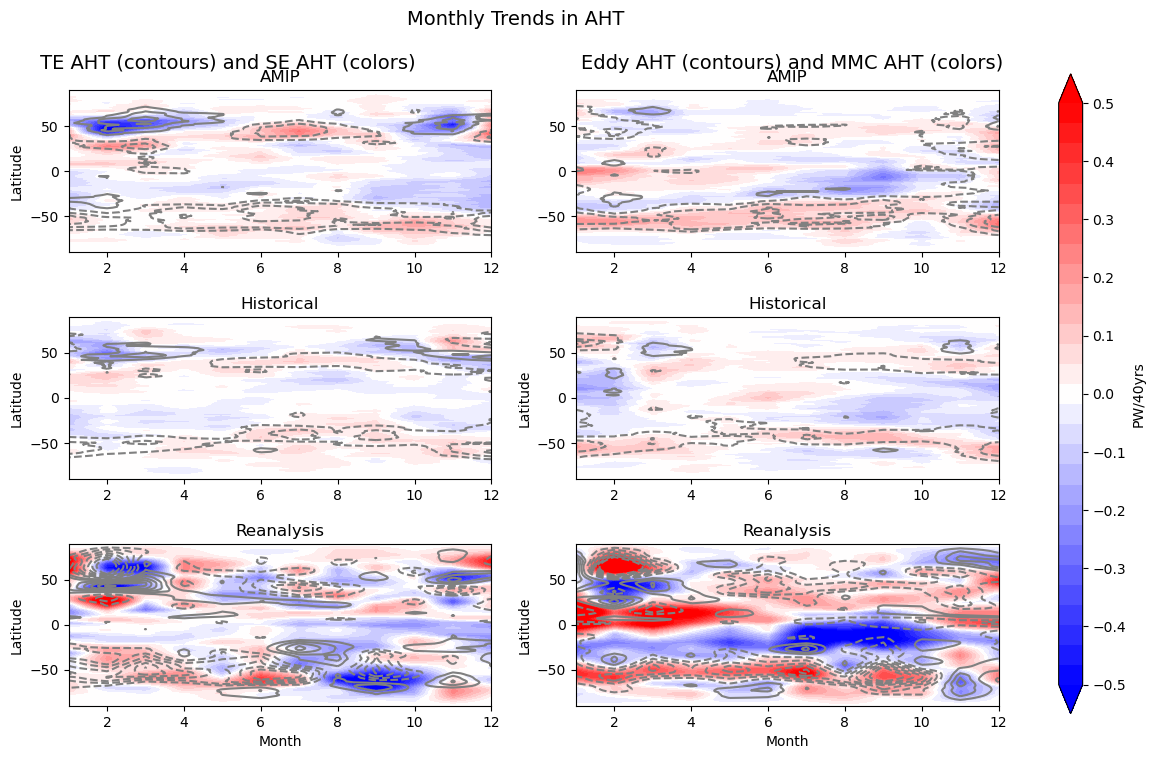

In [83]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'se_aht_polyfit_coefficients'

field3 = 'eddy_aht_polyfit_coefficients'
field4 = 'mmc_aht_polyfit_coefficients'

mmc_levels = [-0.7, -0.6, -0.5, -.4, -.3, -0.2, -0.1, 0.1, 0.2, .3, .4, .5, .6, .7]

eddy_levels = np.linspace(-0.5, 0.5, 30)

fig, axs = plt.subplots(3, 2,  figsize=(12, 8))

axs[0,0].contour(range(1,13), lats, amip_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

axs[0,0].contourf(range(1,13), lats, amip_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,0].set_title('AMIP')
#axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Latitude')

axs[0,1].contour(range(1,13), lats, amip_trends_month[field3].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

axs[0,1].contourf(range(1,13), lats, amip_trends_month[field4].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,1].set_title('AMIP')
#axs[0,1].set_xlabel('Month')
#axs[0,1].set_ylabel('Latitude')


axs[1,0].contour(range(1,13), lats, hist_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[1,0].contourf(range(1,13), lats, hist_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[1,0].set_title('Historical')
#axs[1,1].set_xlabel('Month')
axs[1,0].set_ylabel('Latitude')

axs[1,1].contour(range(1,13), hist_trends_month.latitude, hist_trends_month[field3].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[1,1].contourf(range(1,13), hist_trends_month.latitude, hist_trends_month[field4].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[1,1].set_title('Historical')
#axs[1,0].set_xlabel('Month')
axs[1,1].set_ylabel('Latitude')

axs[2,0].contour(range(1,13), reanalysis_trends_month.latitude, reanalysis_trends_month[field1].sel(degree=1).median('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[2,0].contourf(range(1,13), reanalysis_trends_month.latitude, reanalysis_trends_month[field2].sel(degree=1).median('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[2,0].set_title('Reanalysis')
axs[2,0].set_xlabel('Month')
axs[2,0].set_ylabel('Latitude')

axs[2,1].contour(range(1,13), reanalysis_trends_month.latitude, reanalysis_trends_month[field3].sel(degree=1).mean('model').T,
             levels=mmc_levels,  colors='grey')

contf = axs[2,1].contourf(range(1,13), reanalysis_trends_month.latitude, reanalysis_trends_month[field4].sel(degree=1).mean('model').T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[2,1].set_title('Reanalysis')
axs[2,1].set_xlabel('Month')
axs[2,1].set_ylabel('Latitude')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(contf, cax=cbar_ax, ticks=np.arange(-0.7, 0.8, .1), label='PW/40yrs')

fig.suptitle(f'Monthly Trends in AHT \n \n TE AHT (contours) and SE AHT (colors)                           Eddy AHT (contours) and MMC AHT (colors)',fontsize=14)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

#plt.savefig('../figures/1_20_23_meeting/monthly_aht_trends_reanalysis_amip_historical')
plt.show()

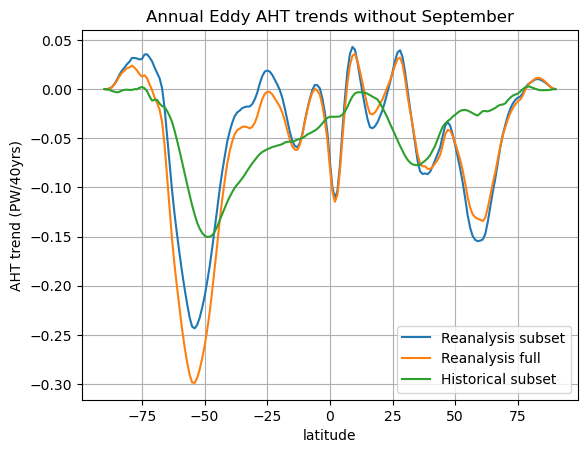

In [65]:
month_sel = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]
reanalysis_trend_subset = reanalysis_trends_month.sel(month=reanalysis_trends_month.month.isin(month_sel)).mean('month').sel(degree=1).mean('model')
hist_trend_subset = hist_trends_month.sel(month=reanalysis_trends_month.month.isin(month_sel)).mean('month').sel(degree=1).mean('model')
reanalysis_trend_full = reanalysis_trends.sel(degree=1).mean('model')

#amip_trend_subset = amip_trends_month.sel(month=reanalysis_trends_month.month.isin(month_sel)).mean('month').sel(degree=1).mean('model')

field = 'eddy_aht_polyfit_coefficients'
reanalysis_trend_subset[field].plot(label='Reanalysis subset')
(40 / 1e15 * reanalysis_trend_full[field]).plot(label='Reanalysis full')
#amip_trend_subset[field].plot(label='AMIP')
hist_trend_subset[field].plot(label='Historical subset')
#(40 / 1e15 * hist_trend_full[field]).plot(label='Historical all')
plt.legend(loc=0)
plt.grid()
plt.title('Annual Eddy AHT trends without September')
plt.ylabel('AHT trend (PW/40yrs)')

#plt.savefig('../figures/1_20_23_meeting/annual_eddy_aht_trends_no_sept')
plt.show()

In [66]:
                 
interactive_models = ['CESM2-WACCM', 'CNRM-ESM2-1', 'GFDL-ESM4', 'MRI-ESM2-0', 'UKESM1-0-LL', 'CNRM-CM6-1',
                      'E3SM-1-0', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-2-G', 'GISS-E2-1-H']
all_models = list(hist_ds.model.values)

non_interactive_models = list(set(all_models) - set(list(interactive_models)))

vals_interactive = []
vals_non_interactive = []

vals = hist_trends_month.se_aht_polyfit_coefficients.sel(month=10).sel(degree=1).sel(latitude=slice(-70, -50)).mean('latitude').values
models =  hist_trends_month.model.values

reanalysis_vals = reanalysis_trends_month.se_aht_polyfit_coefficients.sel(month=10).sel(degree=1).sel(latitude=slice(-70, -50)).mean(['latitude', 'model']).values

print(f'Reanalysis ave is {np.round(reanalysis_vals, 2)}')

for i in range(len(vals)):
    
    #if models[i] in non_interactive_models:
        #vals_non_interactive.append(vals[i])
    if models[i] not in interactive_models:
        vals_non_interactive.append(vals[i])
    elif models[i] in interactive_models:
        vals_interactive.append(vals[i])
    
    #print(f'{models[i]}: {round(vals[i], 2)}')

print(f' Interactive {round(np.mean(np.array(vals_interactive)), 2)} for {len(vals_interactive)} values')
print(f' Non-interactive {round(np.mean(np.array(vals_non_interactive)), 2)} for {len(vals_non_interactive)} values')


Reanalysis ave is -0.3
 Interactive -0.12 for 4 values
 Non-interactive 0.07 for 28 values


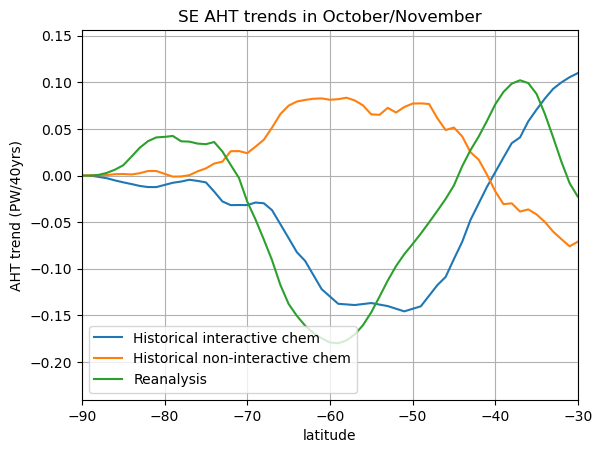

In [71]:
which_month = [10, 11]
hist_interactive = hist_trends_month.sel(month=which_month).sel(model = hist_trends.model.isin(interactive_models)).sel(degree=1).median(['model']).mean('month')
hist_non_interactive = hist_trends_month.sel(month=which_month).sel(model = hist_trends.model.isin(non_interactive_models)).sel(degree=1).median(['model']).mean('month')

(hist_interactive.se_aht_polyfit_coefficients).plot.line(x='latitude', label='Historical interactive chem')
(hist_non_interactive.se_aht_polyfit_coefficients).plot.line(x='latitude', label='Historical non-interactive chem')
(reanalysis_trends_month.sel(month=which_month).mean('month').se_aht_polyfit_coefficients.sel(degree=1).median('model')).plot.line(x='latitude', label='Reanalysis')
plt.legend(loc=0)

plt.grid()
plt.title('SE AHT trends in October/November')
plt.ylabel('AHT trend (PW/40yrs)')
plt.xlim([-90, -30])
#plt.savefig('../figures/1_20_23_meeting/eddy_aht_trends_Oct_Nov_reanalysis_hist_interactive')
plt.show()

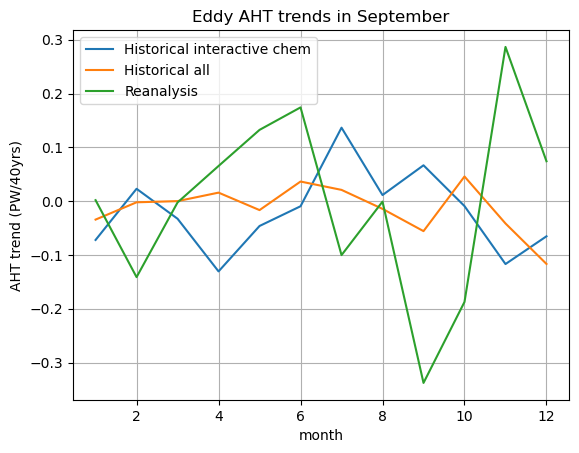

In [48]:
which_lat = -70
hist_interactive = hist_trends_month.sel(latitude=which_lat).sel(model = hist_trends.model.isin(interactive_models)).sel(degree=1).median(['model'])
hist_non_interactive = hist_trends_month.sel(latitude=which_lat).sel(model = hist_trends.model.isin(non_interactive_models)).sel(degree=1).median(['model'])

(hist_interactive.eddy_aht_polyfit_coefficients).plot.line(x='month', label='Historical interactive chem')
(hist_non_interactive.eddy_aht_polyfit_coefficients).plot.line(x='month', label='Historical all')
(reanalysis_trends_month.sel(latitude=which_lat).eddy_aht_polyfit_coefficients.sel(degree=1).median('model')).plot.line(x='month', label='Reanalysis')
plt.legend(loc=0)

plt.grid()
plt.title('Eddy AHT trends in September')
plt.ylabel('AHT trend (PW/40yrs)')

#plt.savefig('../figures/1_20_23_meeting/eddy_aht_trends_September_reanalysis_hist_all_hist_interactive')
plt.show()

In [49]:
all_models = list(hist_ds.model.values)

non_interactive_models = list(set(all_models) - set(list(interactive_models)))

non_interactive_models

['CAS-ESM2-0',
 'MPI-ESM1-2-HR',
 'IPSL-CM6A-LR-INCA',
 'EC-Earth3-CC',
 'MPI-ESM1-2-LR',
 'CMCC-CM2-SR5',
 'EC-Earth3-Veg',
 'NESM3',
 'AWI-ESM-1-1-LR',
 'NorESM2-LM',
 'AWI-CM-1-1-MR',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'CMCC-ESM2',
 'BCC-ESM1',
 'INM-CM4-8',
 'CanESM5-1',
 'IITM-ESM',
 'CESM2-WACCM-FV2',
 'CMCC-CM2-HR4',
 'BCC-CSM2-MR',
 'FIO-ESM-2-0',
 'NorESM2-MM',
 'FGOALS-g3',
 'IPSL-CM6A-LR',
 'FGOALS-f3-L',
 'INM-CM5-0',
 'CanESM5']

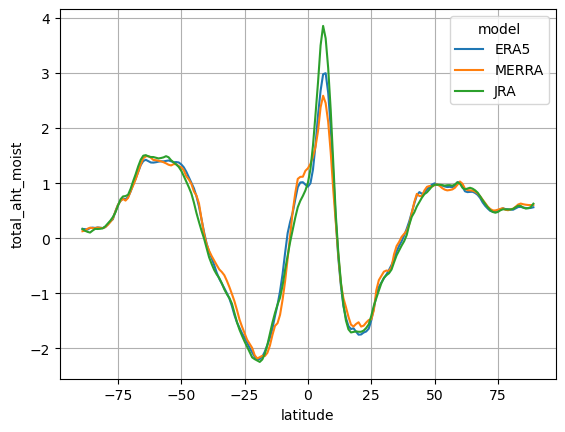

In [50]:

circumf = 2 * np.pi * a * np.cos(np.deg2rad(lats))
p_minus_e_clima = (-reanalysis_ds.total_aht_moist.mean('time').differentiate('latitude')) / (circumf * 111111)

(1000 * 60 * 60 * 24 * p_minus_e_clima[:,1:-1] / (L * 1000)).plot.line(x='latitude')

#plt.ylim([-5e8, 5e8])
plt.grid()
plt.show()

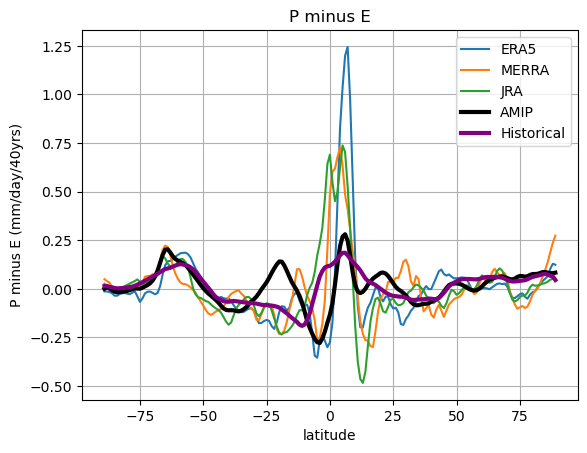

In [78]:
circumf = 2 * np.pi * a * np.cos(np.deg2rad(lats))
p_minus_e_trend = (-reanalysis_trends.total_aht_moist_polyfit_coefficients.sel(degree=1).differentiate('latitude')) / (circumf * 111111)
p_minus_e_trend_amip = (-amip_trends.total_aht_moist_polyfit_coefficients.sel(degree=1).differentiate('latitude')) / (circumf * 111111)
p_minus_e_trend_hist = (-hist_trends.total_aht_moist_polyfit_coefficients.sel(degree=1).differentiate('latitude')) / (circumf * 111111)

for i in range(3):
    (40 * 1000 * 60 * 60 * 24 * p_minus_e_trend[:,1:-1] / (L * 1000)).isel(model=i).plot.line(x='latitude', label=reanalysis_ds.model.values[i])
(40 * 1000 * 60 * 60 * 24 * p_minus_e_trend_amip[:,1:-1] / (L * 1000)).mean('model').plot.line(x='latitude', lw=3, color='k', label='AMIP')
(40 * 1000 * 60 * 60 * 24 * p_minus_e_trend_hist[:,1:-1] / (L * 1000)).mean('model').plot.line(x='latitude', lw=3, color='purple', label='Historical')

plt.legend(loc=0)
plt.grid()

plt.ylabel('P minus E (mm/day/40yrs)')
plt.title('P minus E')
plt.show()

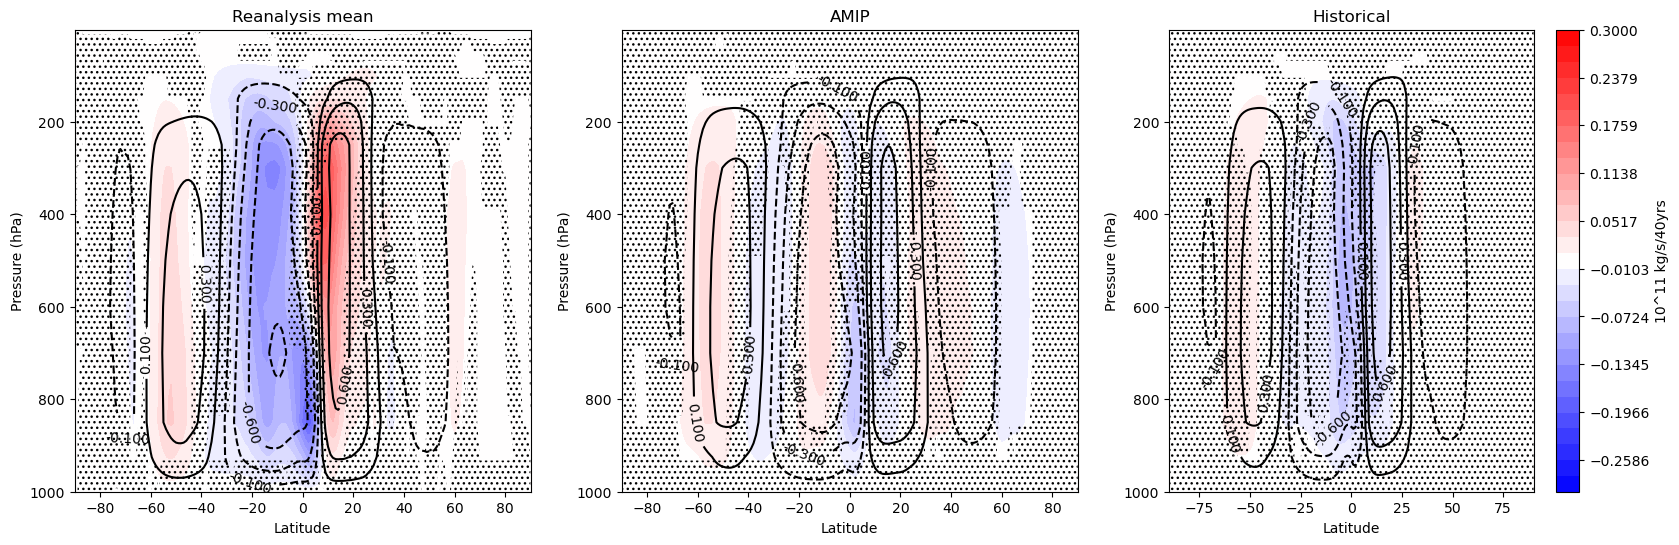

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))

model_thresh = 0.9
which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]

cont=axs[0].contour(lats, levels_hPa, reanalysis_ds.strm_fnct.mean(['time', 'model'])/1e11, levels=which_levels, colors='k')

contf = axs[0].contourf(lats, levels_hPa, reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1).mean('model') * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')

threshold = 3

counts_pos = xr.where(reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1) > 0, 1, 0).sum('model')
counts_neg = xr.where(reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1) < 0, 1, 0).sum('model')
combo = xr.where((counts_pos==threshold) | (counts_neg==threshold), 1, 0)

#To shade where they don't all agree
axs[0].contourf(lats, levels_hPa, combo, levels=[0, 0.9, 10], colors='none',
             hatches=['...', None, None], )

#To shade where they do all agree
#plt.contourf(tot_mean.latitude, tot_mean.level, combo, levels=[0, 0.9, 10], colors='none', hatches=[None, '..', None], )

#axs[0].colorbar(contf, label='10^11 kg/s/40yrs')


axs[0].invert_yaxis()

def fmt(x):
    rounded = f"{x:1f}"
    return rounded

axs[0].clabel(cont, cont.levels, inline=True,  fontsize=10)

axs[0].set_xlabel('Latitude')
axs[0].set_ylabel('Pressure (hPa)')
axs[0].set_title('Reanalysis mean')
#plt.savefig('../figures/Nov_22/reanalysis_stream_fnct_mean_changes')
#plt.show()

cont=axs[1].contour(lats, levels_hPa, amip_ds.strm_fnct.mean(['time', 'model'])/1e11, levels=which_levels, colors='k')

contf = axs[1].contourf(lats, levels_hPa, amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1).mean('model') * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')


threshold = int(model_thresh * len(amip_ds.model))

counts_pos = xr.where(amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1) > 0, 1, 0).sum('model')
counts_neg = xr.where(amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1) < 0, 1, 0).sum('model')
combo = xr.where((counts_pos>=threshold) | (counts_neg>=threshold), 1, 0)

#To shade where they don't all agree
axs[1].contourf(lats, levels_hPa, combo, levels=[0, 0.9, 10], colors='none',
             hatches=['...', None, None])

#To shade where they do all agree
#plt.contourf(all_strm_fnct.latitude, all_strm_fnct.level/100, combo, levels=[0, 0.9, 10], colors='none',hatches=[None, '..', None], )

#plt.colorbar(contf, label='10^11 kg/s/40yrs')

axs[1].invert_yaxis()

def fmt(x):
    rounded = f"{x:1f}"
    return rounded

axs[1].clabel(cont, cont.levels, inline=True,  fontsize=10)

axs[1].set_xlabel('Latitude')
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('AMIP')
#plt.savefig('../figures/Nov_22/amip_stream_fnct_mean_changes')
#plt.show()

cont=axs[2].contour(lats, levels_hPa, hist_ds.strm_fnct.mean(['time', 'model'])/1e11, levels=which_levels, colors='k')

contf = axs[2].contourf(lats, levels_hPa, hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1).mean('model') * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')


threshold = int(model_thresh * len(hist_ds.model))

counts_pos = xr.where(hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1) > 0, 1, 0).sum('model')
counts_neg = xr.where(hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1) < 0, 1, 0).sum('model')
combo = xr.where((counts_pos>=threshold) | (counts_neg>=threshold), 1, 0)

#To shade where they don't all agree
axs[2].contourf(lats, levels_hPa, combo, levels=[0, 0.9, 10], colors='none',
             hatches=['...', None, None])

#To shade where they do all agree
#plt.contourf(all_strm_fnct.latitude, all_strm_fnct.level/100, combo, levels=[0, 0.9, 10], colors='none',hatches=[None, '..', None], )

fig.colorbar(contf, ax=axs[2], label='10^11 kg/s/40yrs')

axs[2].invert_yaxis()

def fmt(x):
    rounded = f"{x:1f}"
    return rounded

plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

axs[2].set_xlabel('Latitude')
axs[2].set_ylabel('Pressure (hPa)')
axs[2].set_title('Historical')
#plt.savefig('../figures/1_20_23_meeting/amip_hist_reanalysis_stream_fnct_changes')
plt.show()

In [ ]:
amip_sst = xr.open_dataset('../amip_ssts.nc').tosbcs.sel(time=slice('1980-01-01','2014-12-31'))

amip_sst_trend = amip_sst.groupby('time.year').mean('time').polyfit(dim='year', deg=1)

In [ ]:
amip_sst_trend.polyfit_coefficients.sel(degree=1).plot.contourf(levels=30)

plt.show()

In [ ]:
ersst = xr.open_dataset('../ersstv5.nc').sst.sel(time=slice('1980-01-01','2014-12-31'))
ersst_trend = ersst.groupby('time.year').mean('time').polyfit(dim='year', deg=1)

In [ ]:
#ersst_trend.polyfit_coefficients.sel(degree=1).plot.contourf(levels=30)
(40 * ersst_trend.polyfit_coefficients.sel(degree=1).mean('lon')).plot()


plt.ylabel('K/40yrs')
plt.title('ERSSTv5 SST trends')

plt.grid()
plt.ylim([-0.5, 2.5])
#plt.savefig('../figures/aht_trends_paper_initials/ersst_sst_trends')
plt.show()

In [ ]:
(40 * ersst_trend.polyfit_coefficients.sel(degree=1)).plot.contourf(levels=np.linspace(-3, 3, 30))
plt.title('ERSSTv5 SST trends (K/40yrs)')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

reanalysis_ds.mse_surf.mean('time').plot.line(x='latitude', ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('MSE (J/kg)')
axs[0].set_title('Near-surface MSE climatology')

reanalysis_trends.mse_surf_polyfit_coefficients.sel(degree=1).plot.line(x='latitude', ax=axs[1])
reanalysis_trends.mse_surf_polyfit_coefficients.sel(degree=1).mean('model').plot.line(x='latitude', color='k', lw=2, ax=axs[1])
axs[1].grid()
axs[1].axvline(40)
axs[1].set_ylabel('MSE (J/kg/yr)')
axs[1].set_title('Near-surface MSE trends')

#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_near_surface_mse_mean_and_trends')
plt.show()